(EJMETSIMPLEXREDES)=

# 4.3 Ejemplo del método símplex de redes

```{admonition} Notas para contenedor de docker:

Comando de docker para ejecución de la nota de forma local:

nota: cambiar `<ruta a mi directorio>` por la ruta de directorio que se desea mapear a `/datos` dentro del contenedor de docker.

`docker run --rm -v <ruta a mi directorio>:/datos --name jupyterlab_optimizacion_2 -p 8888:8888 -p 8787:8787 -d palmoreck/jupyterlab_optimizacion_2:3.0.0`

password para jupyterlab: `qwerty`

Detener el contenedor de docker:

`docker stop jupyterlab_optimizacion_2`

Documentación de la imagen de docker `palmoreck/jupyterlab_optimizacion_2:3.0.0` en [liga](https://github.com/palmoreck/dockerfiles/tree/master/jupyterlab/optimizacion_2).

```

---

```{admonition} Al final de esta nota el y la lectora:
:class: tip

* Aplicará el método de símplex de redes para resolver un problema de flujo con costo mínimo. 

* Relacionará definiciones revisadas en las notas de redes y programación lineal con técnicas que se utilizan en el método símplex para manejar cotas superiores y selección de variables no básicas y variables básicas. No se entrará en detalles de implementación, se trabajará sobre la red misma.

```

```{sidebar} El método símplex de redes ...

El problema de flujo con costo mínimo tiene una posición central entre los modelos de optimización de redes, pues abarca una clase amplia de aplicaciones y su solución es muy eficiente. La razón por la que el problema de flujo con costo mínimo se puede resolver eficientemente es que su formulación es un programa lineal y es posible resolverlo con una versión simplificada del método símplex llamada método símplex de redes. 

A grandes rasgos el método símplex de redes realiza los mismos pasos que el método símplex en cada iteración: encontrar la variable básica entrante, determinar la variable básica que sale y obtener la nueva solución básica factible (BF) con el fin de moverse de la solución BF actual a una adyacente mejor. Sin embargo, ejecuta estos pasos en una forma que explota la estructura especial de la red del problema.

```

En esta nota se revisa un ejemplo del uso del método símplex aplicado a problemas de redes con capacidades (variables de decisión con cotas superiores) y resolver un problema de flujo con costo mínimo. Se utilizarán las {ref}`Definiciones generales de flujo en redes <DGFLUJOREDES>` y  el ejemplo de {ref}`flujo en redes <EJFLUJOENREDESYPL>` añadiendo capacidad a los arcos $(A, B)$ y $(C, E)$ igual a $10$ y $80$ respectivamente:

In [1]:
import copy
import pprint

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
def plot_graph_with_edges_trouble_to_visualize(figsize_tuple,
                                               G_to_plot, nodes_position,
                                               nodes_position_modified,
                                               node_labels,
                                               string_for_edges_trouble_to_visualize,
                                               list_of_edges_trouble_to_visualize):
    """
    Auxiliary function to plot graph that have two nodes with arcs in both directions,
    e.g: (A,B) and (B,A).
    """
    if figsize_tuple:
        plt.figure(figsize=figsize_tuple)
        
    nx.draw_networkx_edges(G_to_plot, pos=nodes_position, 
                           min_target_margin=25, connectionstyle="arc3, rad = 0.1",
                           edgelist=G_to_plot.edges())
    nx.draw_networkx_edge_labels(G_to_plot, pos=nodes_position, 
                                 font_size=10)  
    nx.draw_networkx_edges(G_to_plot, pos=nodes_position, 
                           min_target_margin=25, connectionstyle="arc3, rad = 0.1",
                           edgelist=list_of_edges_trouble_to_visualize)
    
    nx.draw_networkx_edge_labels(G_to_plot, pos=nodes_position, 
                                 edge_labels=string_for_edges_trouble_to_visualize,
                                 font_size=10)
    nx.draw_networkx_labels(G_to_plot, pos=nodes_position_modified, 
                            labels=node_labels)
    nx.draw_networkx_nodes(G_to_plot, pos=nodes_position, 
                           node_size=1000)
    plt.axis("off")
    plt.show()
def plot_graph(figsize_tuple, G_to_plot,
               nodes_position,
               nodes_position_modified,
               nodes_labels,
               edge_labels):
    """
    Auxiliary function to plot graph with nodes that have edges with one direction.
    """
  
    if figsize_tuple:
        plt.figure(figsize=figsize_tuple)
        
    nx.draw_networkx_edges(G_to_plot, pos=nodes_position, 
                           min_target_margin=25, connectionstyle="arc3, rad = 0.1")
    nx.draw_networkx_edge_labels(G_to_plot, pos=nodes_position,
                                 edge_labels=edge_labels,
                                 font_size=10)  
    nx.draw_networkx_labels(G_to_plot, pos=nodes_position_modified,
                            labels=nodes_labels)
    nx.draw_networkx_nodes(G_to_plot, pos=nodes_position, 
                           node_size=1000, alpha=0.6)
    plt.axis("off")
    plt.show()
def fill_edge_for_graph_of_upper_bounds(G_to_be_filled, edge_to_be_added, dict_reference):
    """
    Auxiliary function to create metadata of edge thata will be added in graph of upper bounds.
    """
    G_to_be_filled[edge_to_be_added[0]][edge_to_be_added[1]]["weight"] = dict_reference["weight"]
    G_to_be_filled[edge_to_be_added[0]][edge_to_be_added[1]]["capacity"] = dict_reference["capacity"]
    G_to_be_filled[edge_to_be_added[0]][edge_to_be_added[1]]["flow"] = dict_reference["flow"]
def add_edge_to_graph_of_upper_bounds(G_reference, G_simplex_edges_upper_bounds,
                                      edge_to_be_added,
                                      dict_edge_labels):
    """
    Function that will add an input edge to graph of upper bounds.
    """
    G_simplex_edges_upper_bounds.add_edge(edge_to_be_added[0],
                                          edge_to_be_added[1])
    dict_edge_labels[edge_to_be_added] = {}
    dict_edge_labels[edge_to_be_added]["weight"] = G_reference[edge_to_be_added[0]][edge_to_be_added[1]]["weight"]
    dict_edge_labels[edge_to_be_added]["capacity"] = G_reference[edge_to_be_added[0]][edge_to_be_added[1]]["capacity"]
    dict_edge_labels[edge_to_be_added]["flow"] = G_reference[edge_to_be_added[0]][edge_to_be_added[1]]["capacity"]
    fill_edge_for_graph_of_upper_bounds(G_simplex_edges_upper_bounds,
                                        edge_to_be_added, 
                                        dict_edge_labels[edge_to_be_added])
    netflow_node1 = nx.get_node_attributes(G_reference, "netflow")[edge_to_be_added[0]]
    netflow_node_and_netflow1 = nx.get_node_attributes(G_reference, "node_and_netflow")[edge_to_be_added[0]]
    netflow_node2 = nx.get_node_attributes(G_reference, "netflow")[edge_to_be_added[1]]
    netflow_node_and_netflow2 = nx.get_node_attributes(G_reference, "node_and_netflow")[edge_to_be_added[1]]
    nx.set_node_attributes(G_simplex_edges_upper_bounds, {edge_to_be_added[0]: {"netflow": netflow_node1,
                                                                                "node_and_netflow": netflow_node_and_netflow1},
                                                          edge_to_be_added[1]: {"netflow": netflow_node2,
                                                                                "node_and_netflow": netflow_node_and_netflow2}
                                                         })
    return G_simplex_edges_upper_bounds
def plot_graph_with_cycle(figsize_tuple, G_to_plot,
                          nodes_position,
                          nodes_position_modified,
                          nodes_labels,
                          edge_labels,
                          edge_to_be_added):
    """
    Auxiliary function to plot graph with cycle. The graph have edges with one direction.
    """
    if figsize_tuple:
        plt.figure(figsize=figsize_tuple)
        
    nx.draw_networkx_edges(G_to_plot, pos=nodes_position, 
                           min_target_margin=25, connectionstyle="arc3, rad = 0.1",
                           edgelist=G_to_plot.edges())
    nx.draw_networkx_edges(G_to_plot, pos=nodes_and_pos, 
                           min_target_margin=25, connectionstyle="arc3, rad = 0.1",
                           edgelist=[edge_to_be_added],
                           width = 2,
                           style="dashed")    
    
    nx.draw_networkx_edge_labels(G_to_plot, pos=nodes_position,
                                 edge_labels=edge_labels,
                                 font_size=10)  
    nx.draw_networkx_labels(G_to_plot, pos=nodes_position_modified,
                            labels=nodes_labels)
    nx.draw_networkx_nodes(G_to_plot, pos=nodes_position, 
                           node_size=1000, alpha=0.6)
    plt.axis("off")
    plt.show()
def plot_graph_with_cycle_edges_trouble_to_visualize(figsize_tuple,
                                                     G_to_plot,
                                                     nodes_position,
                                                     nodes_position_modified,
                                                     nodes_labels,
                                                     edge_labels,
                                                     edge_to_be_added,
                                                     string_for_edges_trouble_to_visualize
                                                     ):
    """
    Auxiliary function to plot graph with cycle. The graph have edges with both directions,
    e.g: (A,B) and (B,A).
    """
    if figsize_tuple:
        plt.figure(figsize=figsize_tuple)
        
    nx.draw_networkx_edges(G_to_plot, pos=nodes_position, 
                           min_target_margin=25, connectionstyle="arc3, rad = 0.1",
                           edgelist=G_to_plot.edges())
    nx.draw_networkx_edge_labels(G_to_plot, pos=nodes_position,
                                 edge_labels=edge_labels,
                                 font_size=10)    
    nx.draw_networkx_edges(G_to_plot, pos=nodes_and_pos, 
                           min_target_margin=25, connectionstyle="arc3, rad = 0.1",
                           edgelist=[edge_to_be_added],
                           width = 2,
                           style="dashed")    
    nx.draw_networkx_edge_labels(G_to_plot, pos=nodes_position, 
                                edge_labels=string_for_edges_trouble_to_visualize,
                                font_size=10) 
    nx.draw_networkx_labels(G_to_plot, pos=nodes_position_modified,
                            labels=nodes_labels)
    nx.draw_networkx_nodes(G_to_plot, pos=nodes_position, 
                           node_size=1000, alpha=0.6)
    plt.axis("off")
    plt.show()
def add_edge_from_spanning_tree(G_full, G_spanning_tree, edge_to_be_added, edge_labels):
    """
    Function that recieves spanning tree and add an edge to it.
    """
    G_cycle = G_spanning_tree.copy()
    G_cycle.add_edge(edge_to_be_added[0], edge_to_be_added[1])
    G_cycle.add_edge(edge_to_be_added[0], edge_to_be_added[1])
    G_cycle[edge_to_be_added[0]][edge_to_be_added[1]]["weight"] = G_full[edge_to_be_added[0]][edge_to_be_added[1]]["weight"]
    G_cycle[edge_to_be_added[0]][edge_to_be_added[1]]["capacity"] = G_full[edge_to_be_added[0]][edge_to_be_added[1]]["capacity"]
    G_cycle[edge_to_be_added[0]][edge_to_be_added[1]]["flow"] = ""
    edge_labels_new = copy.deepcopy(edge_labels)
    edge_labels_new[edge_to_be_added] = {}
    edge_labels_new[edge_to_be_added]["weight"] = G_cycle[edge_to_be_added[0]][edge_to_be_added[1]]["weight"]
    edge_labels_new[edge_to_be_added]["capacity"] = G_cycle[edge_to_be_added[0]][edge_to_be_added[1]]["capacity"]
    edge_labels_new[edge_to_be_added]["flow"] = G_cycle[edge_to_be_added[0]][edge_to_be_added[1]]["flow"]
    return (G_cycle, edge_labels_new)
def edge_label_change_for_basic_edge_subs(c_d, edge_labels_reference, edge_to_be_added):
    """
    Function that change labels of edges that are in a cycle after adding edge to 
    spanning tree and will be augmented their flow.
    """
    edge_labels_with_flow_change = {}
    edge_labels_with_flow_change = copy.deepcopy(edge_labels_reference)
    for e in edge_labels_with_flow_change.keys():
        if e in c_d.keys():
            if e != edge_to_be_added:
                if c_d[e] == "forward":
                    edge_labels_with_flow_change[e]["flow"] = "".join([str(edge_labels_with_flow_change[e]["flow"]),
                                                                           "+ $flow^+$"])
                    edge_labels_with_flow_change[e]["bool"] = "+" 
                else:
                    edge_labels_with_flow_change[e]["flow"] = "".join([str(edge_labels_with_flow_change[e]["flow"]),
                                                                           "- $flow^+$"])
                    edge_labels_with_flow_change[e]["bool"] = "-"
            else:
                edge_labels_with_flow_change[e]["flow"] = "".join([str(edge_labels_with_flow_change[e]["flow"]),
                                                                       "$flow^+$"]) 
        else:
            edge_labels_with_flow_change[e]["bool"] = 0 
    return edge_labels_with_flow_change
def get_spanning_tree_from_spanning_tree_reference(G_spanning_tree_reference, 
                                                   edge_to_remove,
                                                   edge_to_add):
    """
    Function that output new spanning tree from a reference spanning tree. 
    Removes edge an add new edge to reference spanning tree.
    """
    G_spanning_tree = G_spanning_tree_reference.copy()
    G_spanning_tree.remove_edge(edge_to_remove[0], edge_to_remove[1])
    G_spanning_tree.add_edge(edge_to_add[0], edge_to_add[1])

    return G_spanning_tree
def increase_flow_from_edge_labels_with_flow_change(G_reference,
                                                    G_spanning_tree_reference,
                                                    G_spanning_tree,
                                                    edge_to_add,
                                                    edge_labels_with_flow_change):
    """
    Function that increases and decreases flow for each edge that are in a cycle.
    """
    
    list_edges_spanning_tree = G_spanning_tree.edges()
    edge_labels_spanning_tree = {}
    
    for e in list_edges_spanning_tree:
        if e != edge_to_add:
            edge_labels_spanning_tree[e] = copy.deepcopy(G_spanning_tree_reference[e[0]][e[1]])
            if edge_labels_with_flow_change[e]["bool"] == "+":
                edge_labels_spanning_tree[e]["flow"] = edge_labels_spanning_tree[e]["flow"] + flow_plus
            else:
                if edge_labels_with_flow_change[e]["bool"] == "-":
                    edge_labels_spanning_tree[e]["flow"] = edge_labels_spanning_tree[e]["flow"] - flow_plus
                else:
                    edge_labels_spanning_tree[e]["flow"] = edge_labels_spanning_tree[e]["flow"]
    
        if e == edge_to_add:
            edge_labels_spanning_tree[e] = {}
            edge_labels_spanning_tree[e]["weight"] = G_reference[edge_to_add[0]][edge_to_add[1]]["weight"]
            edge_labels_spanning_tree[e]["capacity"] = G_reference[edge_to_add[0]][edge_to_add[1]]["capacity"]
            edge_labels_spanning_tree[e]["flow"] = flow_plus 
            
    
    for e in G_spanning_tree.edges():
        G_spanning_tree[e[0]][e[1]]["flow"] = edge_labels_spanning_tree[e]["flow"]
        if e==edge_to_add:
            G_spanning_tree[e[0]][e[1]]["weight"] = edge_labels_spanning_tree[e]["weight"]
            G_spanning_tree[e[0]][e[1]]["capacity"] = edge_labels_spanning_tree[e]["capacity"]    
    
    return (G_spanning_tree, edge_labels_spanning_tree)
def fix_orientation(c_d, edge):
    """
    Auxiliary function that changes orientation acoording to direction of edge.
    """
    if c_d[edge] == "reverse":
        for k,v in c_d.items():
            if c_d[k] == "forward":
                c_d[k] = "reverse"
            else:
                c_d[k] = "forward"
def compute_cost_for_unit_increment(c_d, e_w_d):
    """
    Function that computes unit cost per increment.
    """
    m_number_of_edges_simplex_cycle = len(e_w_d)
    weights_array = np.zeros(m_number_of_edges_simplex_cycle)
    for j,k in enumerate(c_d.keys()):
        if c_d[k] == "forward":
            weights_array[j] = e_w_d[k]
        else:
            weights_array[j] = -1*e_w_d[k]
    return weights_array
def get_new_network_after_upper_bound_technique(G_reference, edge_to_be_removed,
                                                edge_to_be_added):
    """
    Function that output new network after upper bound technique.
    """
    G_new = G_reference.copy()
    G_new.remove_edge(edge_to_be_removed[0], edge_to_be_removed[1])
    G_new.add_edge(edge_to_be_added[0], edge_to_be_added[1])
    list_edges_new = G_new.edges()
    value_for_netflow_change = G_reference[edge_to_be_removed[0]][edge_to_be_removed[1]]["capacity"]
    
    edge_labels_reference = G_reference.edges()
    edge_labels_new = {}
    
    for e in list_edges_new:
        if e != edge_to_be_added:
            edge_labels_new[e] = copy.deepcopy(edge_labels_reference[e])
        else:
            edge_labels_new[e] = {}
            edge_labels_new[e]["weight"] = - G_reference[edge_to_be_removed[0]][edge_to_be_removed[1]]["weight"]
            edge_labels_new[e]["capacity"] = G_reference[edge_to_be_removed[0]][edge_to_be_removed[1]]["capacity"]
    
    
    G_new[edge_to_be_added[0]][edge_to_be_added[1]]["weight"] =   edge_labels_new[edge_to_be_added]["weight"]
    G_new[edge_to_be_added[0]][edge_to_be_added[1]]["capacity"] = edge_labels_new[edge_to_be_added]["capacity"]
    
    new_netflow_1 = value_for_netflow_change + nx.get_node_attributes(G_reference, "netflow")[edge_to_be_added[0]]
    new_netflow_2 = nx.get_node_attributes(G_reference, "netflow")[edge_to_be_added[1]]- value_for_netflow_change
    
    node_and_netflow_1 = "".join([str(edge_to_be_added[0]), '[', str(new_netflow_1),']'])
    node_and_netflow_2 = "".join([str(edge_to_be_added[1]), '[', str(new_netflow_2),']'])
    
    nx.set_node_attributes(G_new, {edge_to_be_added[0]: {"netflow": new_netflow_1,
                                                         "node_and_netflow": node_and_netflow_1},
                                        edge_to_be_added[1]: {"netflow": new_netflow_2,
                                                              "node_and_netflow": node_and_netflow_2}
                                    })
    return (G_new, edge_labels_new)
def update_netflows_after_upper_bound_technique(G,
                                                value_for_netflow_change,
                                                edge_of_nodes_that_will_change_netflow):
    """
    Function that update netflows of each node after upper bound technique.
    """
    new_netflow_1 = value_for_netflow_change + nx.get_node_attributes(G, "netflow")[edge_of_nodes_that_will_change_netflow[1]]
    new_netflow_2 = nx.get_node_attributes(G, "netflow")[edge_of_nodes_that_will_change_netflow[0]]- value_for_netflow_change
    
    new_node_and_netflow_1 = "".join([str(edge_of_nodes_that_will_change_netflow[1]), '[', str(new_netflow_1),']'])
    new_node_and_netflow_2 = "".join([str(edge_of_nodes_that_will_change_netflow[0]), '[', str(new_netflow_2),']'])
    nx.set_node_attributes(G, {edge_of_nodes_that_will_change_netflow[1]: {"netflow": new_netflow_1,
                                                                           "node_and_netflow": new_node_and_netflow_1},
                               edge_of_nodes_that_will_change_netflow[0]: {"netflow": new_netflow_2,
                                                                           "node_and_netflow": new_node_and_netflow_2}
                               }) 

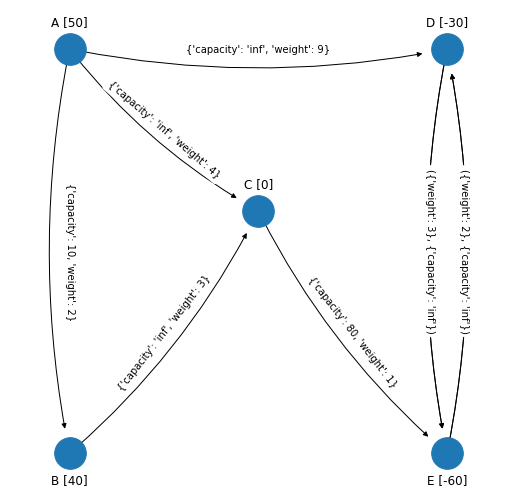

In [3]:
nodes_pos = [[0.18181818181818182, 0.7272727272727273],
             [0.18181818181818182, 0.2727272727272727],
             [0.5454545454545454, 0.2727272727272727],
             [0.5454545454545454, 0.7272727272727273],
             [0.36363636363636365, 0.5454545454545454]]

nodes = ['A', 'B', 'E', 'D', 'C']

nodes_and_pos = dict(zip(nodes, nodes_pos))

G_min_cost_flow = nx.DiGraph()

G_min_cost_flow.add_node('A', netflow = 50,  node_and_netflow="A [50]")
G_min_cost_flow.add_node('B', netflow = 40,  node_and_netflow="B [40]")
G_min_cost_flow.add_node('C', netflow = 0,   node_and_netflow="C [0]")
G_min_cost_flow.add_node('D', netflow = -30, node_and_netflow="D [-30]")
G_min_cost_flow.add_node('E', netflow = -60, node_and_netflow="E [-60]")

edge_labels_min_cost_flow = {('A', 'B'): {"weight": 2, "capacity": 10},
                             ('A', 'C'): {"weight": 4, "capacity": "inf"},
                             ('A', 'D'): {"weight": 9, "capacity": "inf"},
                             ('B', 'C'): {"weight": 3, "capacity": "inf"},
                             ('C', 'E'): {"weight": 1, "capacity": 80},
                             ('E', 'D'): {"weight": 2, "capacity": "inf"},
                             ('D', 'E'): {"weight": 3, "capacity": "inf"}
                            }


G_min_cost_flow.add_edges_from(edge_labels_min_cost_flow)
for e in G_min_cost_flow.edges():
    G_min_cost_flow[e[0]][e[1]]["capacity"] = edge_labels_min_cost_flow[e]["capacity"]
    G_min_cost_flow[e[0]][e[1]]["weight"] = edge_labels_min_cost_flow[e]["weight"]


n1 = G_min_cost_flow['E']['D']
n2 = G_min_cost_flow['D']['E']

n1["weight"] = 2
n1["capacity"] = "inf"

n2["weight"] = 3
n2["capacity"]= "inf"


stri1 = f'{({"weight": n1["weight"]},{"capacity": n1["capacity"]},)}'
stri2 = f'\n\n\n'
stri3 = f'{({"weight": n2["weight"]}, {"capacity": n2["capacity"]},)}'
string_for_edges_trouble_to_visualize_min_cost_flow = {('D', 'E'): ''.join([stri1, stri2, stri3])}

list_of_edges_trouble_to_visualize_min_cost_flow = [('D', 'E'), ('E', 'D')]
    
node_labels_min_cost_flow = nx.get_node_attributes(G_min_cost_flow, "node_and_netflow")

nodes_pos_modified = {}

y_off = 0.03

nodes_and_pos_modified = copy.deepcopy(nodes_and_pos)

for node in G_min_cost_flow.nodes():
    if node == 'B' or node == 'E':
        nodes_and_pos_modified[node] =  [nodes_and_pos_modified[node][0], 
                                         nodes_and_pos_modified[node][1] - y_off]
    else:
        nodes_and_pos_modified[node] =  [nodes_and_pos_modified[node][0], 
                                         nodes_and_pos_modified[node][1] + y_off]
        

figsize_tuple = (9, 9)
plot_graph_with_edges_trouble_to_visualize(figsize_tuple,
                                           G_min_cost_flow, nodes_and_pos,
                                           nodes_and_pos_modified,
                                           node_labels_min_cost_flow,
                                           string_for_edges_trouble_to_visualize_min_cost_flow,
                                           list_of_edges_trouble_to_visualize_min_cost_flow)

En la red anterior el arco $(D, E)$ tiene costo igual a $3$ y el arco $(E, D)$ tiene costo igual a $2$.

Al lado de cada nodo en corchetes se presenta el flujo neto generado por el nodo. Los nodos origen tienen un flujo neto positivo y en la red son los nodos "A" y "B" (por ejemplo fábricas). Los nodos destino tienen un flujo neto negativo que en la red son los nodos "D" y "E" (por ejemplo clientes). El único nodo de transbordo es el nodo "C" que tiene flujo neto igual a cero (centro de distribución por ejemplo). Los valores de los costos se muestran en los arcos.

Entonces el modelo de PL que minimiza el costo de transferencia de flujo de modo que el **flujo neto** satisfaga lo representado en la red, considerando el flujo neto como el flujo total que sale del nodo menos el flujo total que entra al nodo es:

$$\displaystyle \min 2 x_{AB} + 4 x_{AC} + 9 x_{AD} + 3 x_{BC} + x_{CE} + 3 x_{DE} + 2x_{ED}$$

$$\text{sujeto a: }$$

$$
\begin{eqnarray}
&x_{AB}&  + &x_{AC}& + &x_{AD}&   &&         &&         &&         &&       &=& 50 \nonumber \\
&-x_{AB}&   &&         &&       + &x_{BC}&   &&         &&         &&       &=& 40 \nonumber \\
&&        - &x_{AC}&   &&       - &x_{BC}& + &x_{CE}&   &&         &&       &=& 0 \nonumber \\
&&          &&       - &x_{AD}&   &&         &&       + &x_{DE}& - &x_{ED}& &=& -30 \nonumber \\
&&          &&         &&         &&       - &x_{CE}& - &x_{DE}& + &x_{ED}& &=& -60 \nonumber
\end{eqnarray}
$$

$$x_{AB} \leq 10, x_{CE} \leq 80$$

$$x_{ij} \geq 0 \forall i,j$$

La primer restricción de igualdad representa el flujo neto para el nodo $A$ y la última el flujo neto para el nodo $E$. A tales ecuaciones de las restricciones de igualdad se les conoce con el nombre de **ecuaciones de conservación de flujo**.

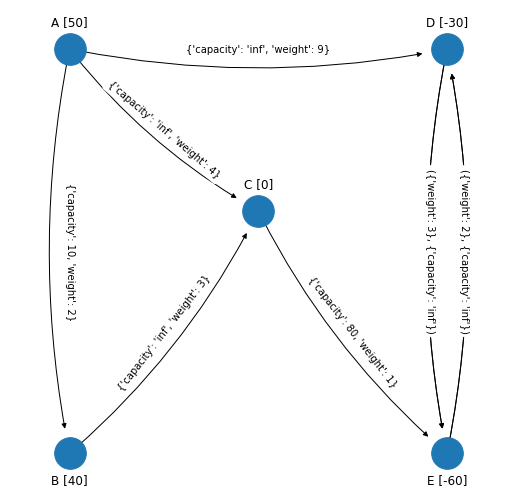

In [4]:
figsize_tuple = (9, 9)
plot_graph_with_edges_trouble_to_visualize(figsize_tuple,
                                           G_min_cost_flow, nodes_and_pos,
                                           nodes_and_pos_modified,
                                           node_labels_min_cost_flow,
                                           string_for_edges_trouble_to_visualize_min_cost_flow,
                                           list_of_edges_trouble_to_visualize_min_cost_flow)

La red solución (omitiendo arcos con flujo igual a cero) es:

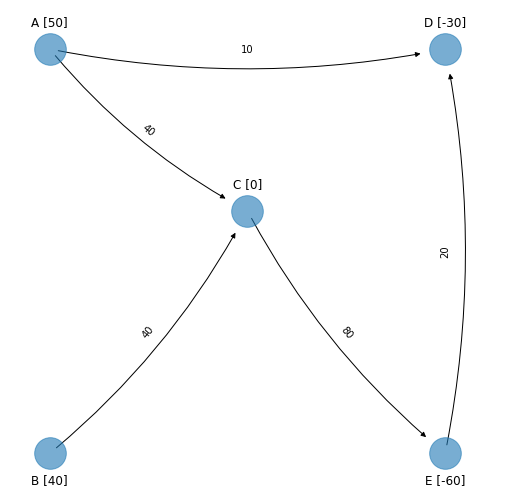

In [5]:
G_min_cost_flow_solution = nx.DiGraph()

G_min_cost_flow_solution.add_node('A', netflow = 50,  node_and_netflow="A [50]")
G_min_cost_flow_solution.add_node('B', netflow = 40,  node_and_netflow="B [40]")
G_min_cost_flow_solution.add_node('C', netflow = 0,   node_and_netflow="C [0]")
G_min_cost_flow_solution.add_node('D', netflow = -30, node_and_netflow="D [-30]")
G_min_cost_flow_solution.add_node('E', netflow = -60, node_and_netflow="E [-60]")

edge_flows = {('A', 'C'): 40,
              ('A', 'D'): 10,
              ('B', 'C'): 40,
              ('C', 'E'): 80,            
              ('E', 'D'): 20
              }

G_min_cost_flow_solution.add_edges_from(edge_flows)
node_labels_min_cost_flow_solution = nx.get_node_attributes(G_min_cost_flow_solution, "node_and_netflow")

figsize_tuple = (9, 9)
plot_graph(figsize_tuple, G_min_cost_flow_solution,
           nodes_and_pos,
           nodes_and_pos_modified,
           node_labels_min_cost_flow_solution,
           edge_flows)

```{margin}

Tal solución se puede verificar utilizando el paquete *Networkx* y ejecutar las instrucciones en el ejemplo de {ref}`flujo con costo mínimo <EJREDFLUJOCOSTOMIN>`, en estas instrucciones se utiliza la función [network_simplex](https://networkx.org/documentation/stable/reference/algorithms/flow.html#network-simplex).

```

La designación del flujo anterior entre todos los nodos incurre en un costo de $490$.

Podemos revisar el contenido de información de los nodos y de los arcos con las siguientes funciones respectivamente:

In [6]:
pprint.pprint(G_min_cost_flow.nodes(data=True))

NodeDataView({'A': {'netflow': 50, 'node_and_netflow': 'A [50]'}, 'B': {'netflow': 40, 'node_and_netflow': 'B [40]'}, 'C': {'netflow': 0, 'node_and_netflow': 'C [0]'}, 'D': {'netflow': -30, 'node_and_netflow': 'D [-30]'}, 'E': {'netflow': -60, 'node_and_netflow': 'E [-60]'}})


In [7]:
pprint.pprint(G_min_cost_flow.edges(data=True))

OutEdgeDataView([('A', 'B', {'capacity': 10, 'weight': 2}), ('A', 'C', {'capacity': 'inf', 'weight': 4}), ('A', 'D', {'capacity': 'inf', 'weight': 9}), ('B', 'C', {'capacity': 'inf', 'weight': 3}), ('C', 'E', {'capacity': 80, 'weight': 1}), ('D', 'E', {'capacity': 'inf', 'weight': 3}), ('E', 'D', {'capacity': 'inf', 'weight': 2})])


## Arcos básicos y no básicos

Supóngase que se tienen $n$ nodos en una red. Se tienen las siguientes definiciones y resultados:

* Toda solución básica factible (BF) tiene $n-1$ variables básicas y representan el flujo por el arco respectivo. Esto resulta de tener una matriz de incidencia con rank igual a $n-1$, ver {ref}`representación de redes: matriz de incidencia nodo-arco<MATINCIDNODOARCO>`.

* Los $n-1$ arcos correspondientes a las variables básicas se les nombra **arcos básicos** y los que corresponden a las variables no básicas son **arcos no básicos.**

* Cualquier conjunto de $n-1$ arcos forma un *spanning tree*, ver {ref}`arborescencia y spanning tree<ARBORYSPANTREE>`.

* Un *spanning tree* solución se obtiene igualando las variables correspondientes a sus *nontree arcs* a cero y las variables correspondientes a sus *tree arcs* de acuerdo al sistema de ecuaciones lineales conformado por las restricciones de los nodos (flujos netos). 

* Un *spanning tree* solución factible es un *spanning tree* solución cuyos arcos satisfacen todas las demás restricciones (por ejemplo no negatividad y cotas superiores).

* Las soluciones básicas son *spanning trees* solución y las soluciones BF son *spanning trees* solución factibles.

### Ejemplo

Tomando como ejemplo la red anterior y el PL asociado:

In [8]:
import sympy

In [9]:
x_AB, x_AC, x_AD, x_BC, x_CE, x_DE, x_ED = sympy.symbols("x_AB, x_AC, x_AD, x_BC, x_CE, x_DE, x_ED")

In [10]:
b = sympy.Matrix([50, 40, 0, -30, -60])

In [11]:
A = sympy.Matrix([[1, 1, 1, 0, 0, 0, 0],
                  [-1, 0, 0, 1, 0, 0, 0],
                  [0, -1, 0, -1, 1, 0, 0],
                  [0, 0, -1, 0, 0, 1, -1],
                  [0, 0, 0, 0, -1, -1, 1]])

In [12]:
x = sympy.Matrix([x_AB, x_AC, x_AD, x_BC, x_CE, x_DE, x_ED])

In [13]:
sympy.pprint(sympy.solve(A*x - b, x))

{x_AB: x_BC - 40, x_AC: -x_BC - x_DE + x_ED + 60, x_AD: x_DE - x_ED + 30, x_CE
: -x_DE + x_ED + 60}


```{margin}

$
\begin{eqnarray}
&x_{AB}&  + &x_{AC}& + &x_{AD}&   &&         &&         &&         &&       &=& 50 \nonumber \\
&-x_{AB}&   &&         &&       + &x_{BC}&   &&         &&         &&       &=& 40 \nonumber \\
&&        - &x_{AC}&   &&       - &x_{BC}& + &x_{CE}&   &&         &&       &=& 0 \nonumber \\
&&          &&       - &x_{AD}&   &&         &&       + &x_{DE}& - &x_{ED}& &=& -30 \nonumber \\
&&          &&         &&         &&       - &x_{CE}& - &x_{DE}& + &x_{ED}& &=& -60 \nonumber
\end{eqnarray}
$

$x_{AB} \leq 10, x_{CE} \leq 80$, $x_{ij} \geq 0 \forall i,j$
```

Una solución no factible del PL pues no cumple con la cota $x_{AB} \geq 0$ es:

In [14]:
def get_solutions_to_linear_system_of_equations(xBC, xDE, xED):
    xAB= xBC - 40 
    xAC= -xBC - xDE + xED + 60 
    xAD= xDE - xED + 30
    xCE= -xDE + xED + 60
    return (xAB, xAC, xAD, xBC, xCE, xDE, xED)

In [15]:
xBC = 0 
xDE = 0
xED = 0
xAB, xAC, xAD, xBC, xCE, xDE, xED = get_solutions_to_linear_system_of_equations(xBC, xDE, xED)

In [16]:
print(xAB, xAC, xAD, xBC, xCE, xDE, xED)

-40 60 30 0 60 0 0


El *spanning tree* solución no factible con sus *nontree* arcs iguales a cero asociado es (omitiendo arcos con flujo igual a cero):


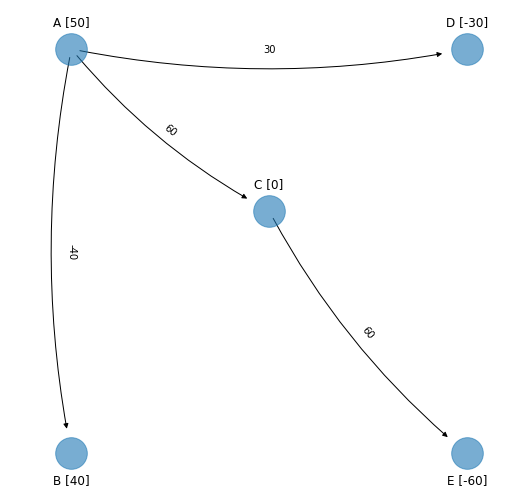

In [17]:
G_spanning_tree_infeasible = nx.DiGraph()

G_spanning_tree_infeasible.add_node('A', netflow = 50,  node_and_netflow="A [50]")
G_spanning_tree_infeasible.add_node('B', netflow = 40,  node_and_netflow="B [40]")
G_spanning_tree_infeasible.add_node('C', netflow = 0,   node_and_netflow="C [0]")
G_spanning_tree_infeasible.add_node('D', netflow = -30, node_and_netflow="D [-30]")
G_spanning_tree_infeasible.add_node('E', netflow = -60, node_and_netflow="E [-60]")

edge_flows_infeasible = {('A', 'B'): xAB,
                         ('A', 'C'): xAC,
                         ('A', 'D'): xAD,
                         ('C', 'E'): xCE,            
                         }

G_spanning_tree_infeasible.add_edges_from(edge_flows_infeasible)
node_labels_infeasible = nx.get_node_attributes(G_spanning_tree_infeasible, 
                                                "node_and_netflow")

figsize_tuple = (9, 9)
plot_graph(figsize_tuple, G_spanning_tree_infeasible,
           nodes_and_pos,
           nodes_and_pos_modified,
           node_labels_infeasible,
           edge_flows_infeasible)

```{margin}

$
\begin{eqnarray}
&x_{AB}&  + &x_{AC}& + &x_{AD}&   &&         &&         &&         &&       &=& 50 \nonumber \\
&-x_{AB}&   &&         &&       + &x_{BC}&   &&         &&         &&       &=& 40 \nonumber \\
&&        - &x_{AC}&   &&       - &x_{BC}& + &x_{CE}&   &&         &&       &=& 0 \nonumber \\
&&          &&       - &x_{AD}&   &&         &&       + &x_{DE}& - &x_{ED}& &=& -30 \nonumber \\
&&          &&         &&         &&       - &x_{CE}& - &x_{DE}& + &x_{ED}& &=& -60 \nonumber
\end{eqnarray}
$

$x_{AB} \leq 10, x_{CE} \leq 80$, $x_{ij} \geq 0 \forall i,j$
```

Una solución factible al PL es:

In [18]:
xBC = 40 
xDE = 0
xED = 0
xAB, xAC, xAD, xBC, xCE, xDE, xED = get_solutions_to_linear_system_of_equations(xBC, xDE, xED)

In [19]:
print(xAB, xAC, xAD, xBC, xCE, xDE, xED)

0 20 30 40 60 0 0


El *spanning tree* solución factible con sus *nontree* arcs iguales a cero asociado es (omitiendo arcos con flujo igual a cero):

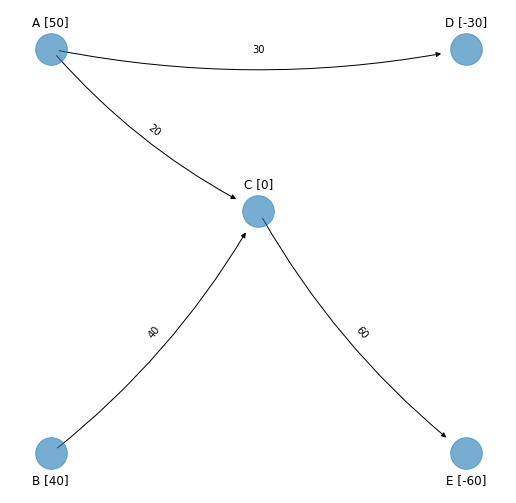

In [20]:
G_spanning_tree_feasible = nx.DiGraph()

G_spanning_tree_feasible.add_node('A', netflow = 50,  node_and_netflow="A [50]")
G_spanning_tree_feasible.add_node('B', netflow = 40,  node_and_netflow="B [40]")
G_spanning_tree_feasible.add_node('C', netflow = 0,   node_and_netflow="C [0]")
G_spanning_tree_feasible.add_node('D', netflow = -30, node_and_netflow="D [-30]")
G_spanning_tree_feasible.add_node('E', netflow = -60, node_and_netflow="E [-60]")

edge_flows_feasible = {('A', 'C'): xAC,
                       ('A', 'D'): xAD,
                       ('B', 'C'): xBC,
                       ('C', 'E'): xCE
                       }

G_spanning_tree_feasible.add_edges_from(edge_flows_feasible)
node_labels_feasible = nx.get_node_attributes(G_spanning_tree_feasible, 
                                              "node_and_netflow")

figsize_tuple = (9, 9)
plot_graph(figsize_tuple, G_spanning_tree_feasible,
           nodes_and_pos,
           nodes_and_pos_modified,
           node_labels_feasible,
           edge_flows_feasible)

```{admonition} Comentario

El método símplex de redes se mueve de un *spanning tree* solución factible a otro *spanning tree* solución factible iterativamente.

```

## Técnica de la cota superior

En este ejemplo se tienen cotas superiores como: $x_{AB} \leq 10$ o $x_{CE} \leq 80$ (capacidades de los arcos) por lo que se debe adaptar el método símplex descrito en el {ref}`ejemplo del método símplex<EJMETSIMPLEXAPLICADOEJPROTOTIPO>` con la técnica de la cota superior.


La idea de la técnica es considerar que el **arco básico** que debido a un incremento llegue a un flujo igual al de su cota superior, sea **reemplazado** por un arco en dirección contraria con la misma capacidad y con costo igual al **negativo** del arco original. Tales arcos los nombramos **arcos inversos**. Además los flujos netos de los nodos deben ajustarse a este cambio.

```{admonition} Comentarios

* Una interpretación de sustituir el arco que tiene un flujo igual a su cota superior por otro en dirección contraria es que el flujo del arco en dirección contraria "cancela" el flujo del arco original. Además un costo igual al negativo del arco original se interpreta como un "ahorro" en la transferencia del flujo.

* El arco original se mantiene como básico con flujo igual a su cota superior y el arco en dirección contraria se considera como no básico. En iteraciones posteriores el arco original aunque es básico no se considera en el análisis para ser sustituido.

* Recuérdese que en el método símplex si al modificar el valor de una variable básica que tiene un valor positivo llega a su cota inferior entonces es una candidata a salir del conjunto de variables básicas. Con cotas superiores las variables básicas que tienen un valor positivo menor a sus cotas, si modifican su valor de modo que llegan a tales cotas también son candidatas a salir del conjunto de variables básicas. Con la técnica de la cota superior se sustituyen estas variables por arcos inversos y "no contribuyen" con análisis posterior alguno hasta que sus arcos inversos modifiquen su valor o se finalice el método.


```

## Inicio del ejemplo

Para comprender la técnica de la cota superior supóngase que en alguna iteración $x_{AB}$ se convirtió en la variable básica que será sustituida pues alcanzó su cota superior de $10$. Por tanto el arco $x_{AB}$ se sustituye por $x_{AB} = 10 - y_{AB}$ con $y_{AB}=0$ y por tanto es una variable no básica "nueva". Entonces se sustituye el arco $(A,B)$ por el arco inverso $(B,A)$ el cual tiene un flujo de $y_{AB}$ con capacidad de $10$ y un costo unitario de $-2$. También $b_B$ aumenta de $40$ a $50$ y $b_A$ disminuye de $50$ a $40$:

```{admonition} Observación
:class: tip

Los ajustes $b_A, b_B$ que se realizan tienen que ver con obtener sistemas de ecuaciones lineales equivalentes con las restricciones de flujo neto del PL.

```

In [21]:
new_netflow_B = G_min_cost_flow['A']['B']["capacity"] + nx.get_node_attributes(G_min_cost_flow, "netflow")['B']

In [22]:
print(new_netflow_B)

50


In [23]:
new_netflow_A = nx.get_node_attributes(G_min_cost_flow, "netflow")['A'] - G_min_cost_flow['A']['B']["capacity"]

In [24]:
print(new_netflow_A)

40


```{margin}

Red original del problema:

```

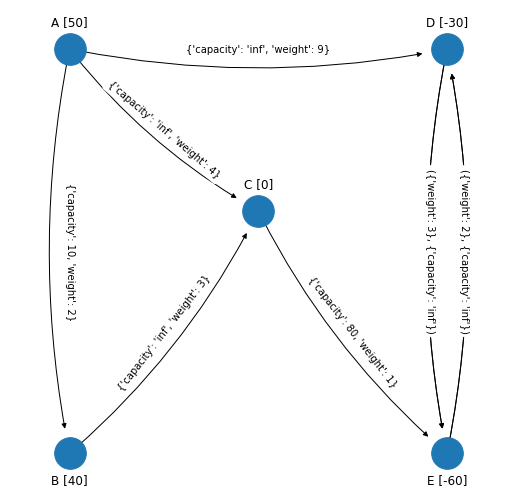

In [25]:
figsize_tuple = (9, 9)
plot_graph_with_edges_trouble_to_visualize(figsize_tuple,
                                           G_min_cost_flow, nodes_and_pos,
                                           nodes_and_pos_modified,
                                           node_labels_min_cost_flow,
                                           string_for_edges_trouble_to_visualize_min_cost_flow,
                                           list_of_edges_trouble_to_visualize_min_cost_flow)

In [26]:
edge_to_remove_from_network = ('A', 'B')
edge_to_add_new_network = ('B', 'A')


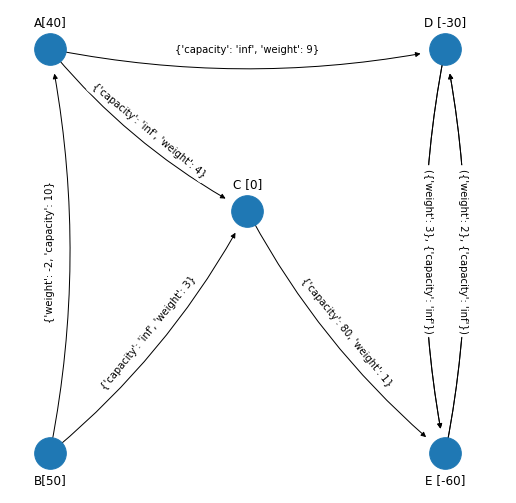

In [27]:
G_simplex,edge_labels_simplex = get_new_network_after_upper_bound_technique(G_min_cost_flow, edge_to_remove_from_network,
                                                                            edge_to_add_new_network)

node_labels_simplex = nx.get_node_attributes(G_simplex, "node_and_netflow")

string_for_edges_trouble_to_visualize_simplex = string_for_edges_trouble_to_visualize_min_cost_flow

list_of_edges_trouble_to_visualize_simplex = list_of_edges_trouble_to_visualize_min_cost_flow

figsize_tuple = (9, 9)
plot_graph_with_edges_trouble_to_visualize(figsize_tuple,
                                           G_simplex, nodes_and_pos,
                                           nodes_and_pos_modified,
                                           node_labels_simplex,
                                           string_for_edges_trouble_to_visualize_simplex,
                                           list_of_edges_trouble_to_visualize_simplex)

Para futura referencia el arco $(A,B)$ que alcanzó la cota superior lo guardamos en la red `G_simplex_edges_upper_bounds` (e iremos guardando los arcos que lleguen a tales cotas):

In [28]:
edge_to_be_added_in_graph_of_upper_bounds = ('A','B')

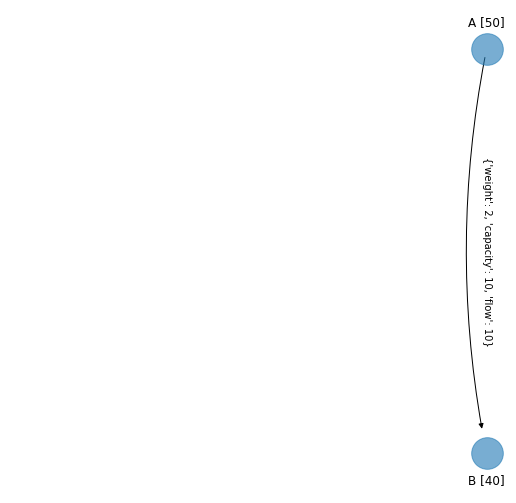

In [29]:
edge_labels_simplex_upper_bounds = {}
G_simplex_edges_upper_bounds = nx.DiGraph()
G_simplex_edges_upper_bounds.add_node(edge_to_be_added_in_graph_of_upper_bounds[0])
G_simplex_edges_upper_bounds.add_node(edge_to_be_added_in_graph_of_upper_bounds[1])

G_simplex_edges_upper_bounds = add_edge_to_graph_of_upper_bounds(G_min_cost_flow,
                                                                 G_simplex_edges_upper_bounds,
                                                                 edge_to_be_added_in_graph_of_upper_bounds,
                                                                 edge_labels_simplex_upper_bounds)

node_labels_simplex_upper_bounds = nx.get_node_attributes(G_simplex_edges_upper_bounds, "node_and_netflow")

figsize_tuple = (9, 9)
plot_graph(figsize_tuple, G_simplex_edges_upper_bounds,
           nodes_and_pos,
           nodes_and_pos_modified,
           node_labels_simplex_upper_bounds,
           edge_labels_simplex_upper_bounds)

Considérese el siguiente *spanning tree* solución factible de la red a la que se le aplicó la técnica de la cota superior y que se muestra en el margen para referencia:

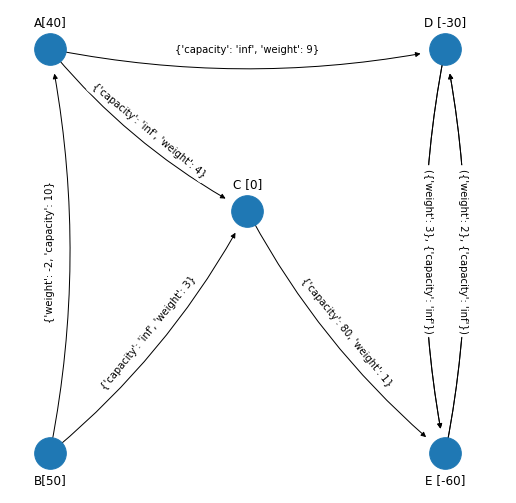

In [30]:
figsize_tuple = (9, 9)
plot_graph_with_edges_trouble_to_visualize(figsize_tuple,
                                           G_simplex, nodes_and_pos,
                                           nodes_and_pos_modified,
                                           node_labels_simplex,
                                           string_for_edges_trouble_to_visualize_simplex,
                                           list_of_edges_trouble_to_visualize_simplex)

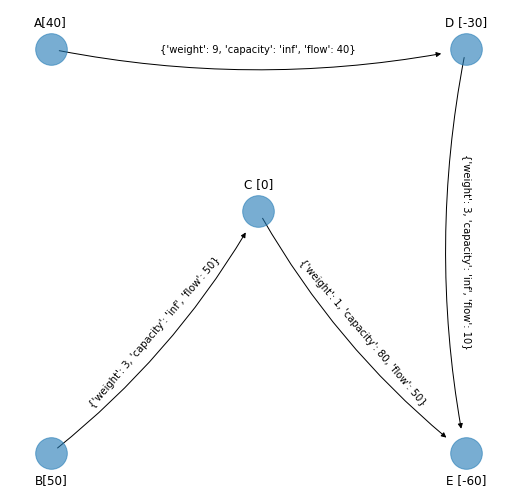

In [30]:
G_simplex_spanning_tree_1 = G_simplex.copy()
G_simplex_spanning_tree_1.remove_edge('B','A')
G_simplex_spanning_tree_1.remove_edge('A', 'C')
G_simplex_spanning_tree_1.remove_edge('E', 'D')

list_edges_spanning_tree_1 = G_simplex_spanning_tree_1.edges()

edge_labels_simplex_spanning_tree_1 = {}

for e in list_edges_spanning_tree_1:
    edge_labels_simplex_spanning_tree_1[e] = copy.deepcopy(edge_labels_min_cost_flow[e])
     
edge_labels_simplex_spanning_tree_1[('A', 'D')]["flow"] = 40
edge_labels_simplex_spanning_tree_1[('B', 'C')]["flow"] = 50
edge_labels_simplex_spanning_tree_1[('C', 'E')]["flow"] = 50
edge_labels_simplex_spanning_tree_1[('D', 'E')]["flow"] = 10

for e in G_simplex_spanning_tree_1.edges():
    G_simplex_spanning_tree_1[e[0]][e[1]]["flow"] = edge_labels_simplex_spanning_tree_1[e]["flow"]


node_labels_simplex_spanning_tree_1 = nx.get_node_attributes(G_simplex_spanning_tree_1, 
                                                            "node_and_netflow")
    
figsize_tuple = (9, 9)
plot_graph(figsize_tuple, G_simplex_spanning_tree_1,
           nodes_and_pos,
           nodes_and_pos_modified,
           node_labels_simplex_spanning_tree_1,
           edge_labels_simplex_spanning_tree_1)


Los valores anteriores de flujo se pueden obtener resolviendo las siguientes ecuaciones de igualdad que resultan con el cambio $x_{AB} = 10 - y_{BA}$ y considerando arcos no básicos: $y_{AB}, x_{AC}, x_{ED}$ que tienen valor igual a $0$:

$$
\begin{eqnarray}
&-y_{AB}&  + &x_{AC}& + &x_{AD}&   &&         &&         &&         &&       &=& 40 \nonumber \\
&y_{AB}&   &&         &&       + &x_{BC}&   &&         &&         &&       &=& 50 \nonumber \\
&&        - &x_{AC}&   &&       - &x_{BC}& + &x_{CE}&   &&         &&       &=& 0 \nonumber \\
&&          &&       - &x_{AD}&   &&         &&       + &x_{DE}& - &x_{ED}& &=& -30 \nonumber \\
&&          &&         &&         &&       - &x_{CE}& - &x_{DE}& + &x_{ED}& &=& -60 \nonumber
\end{eqnarray}
$$

In [31]:
print(nx.get_edge_attributes(G_simplex_spanning_tree_1, "flow"))

{('A', 'D'): 40, ('B', 'C'): 50, ('C', 'E'): 50, ('D', 'E'): 10}


```{admonition} Observación
:class: tip

Aunque es un poco extraña la notación $y_{AB}$ para representar al arco inverso $(B, A)$ (pues pensaríamos en usar $y_{BA}$) esto se asigna con tal notación para mantener la forma de los sistemas de ecuaciones lineales de las restricciones de igualdad. En el sistema anterior el lugar donde se encontraba $x_{AB}$ se sustituye por $y_{AB}$.

```

### Revisión de cuál arco no básico sustituye a un arco básico

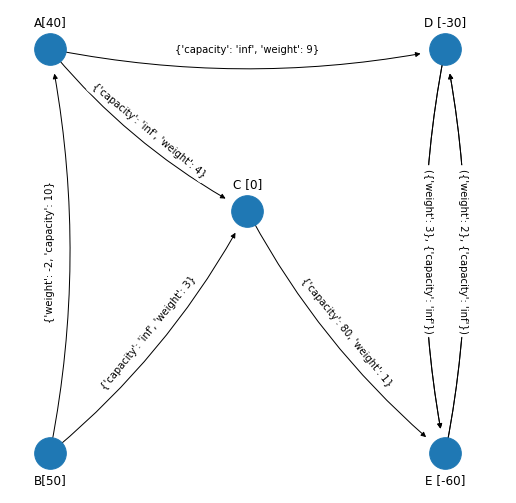

In [32]:
figsize_tuple = (9, 9)
plot_graph_with_edges_trouble_to_visualize(figsize_tuple,
                                           G_simplex, nodes_and_pos,
                                           nodes_and_pos_modified,
                                           node_labels_simplex,
                                           string_for_edges_trouble_to_visualize_simplex,
                                           list_of_edges_trouble_to_visualize_simplex)

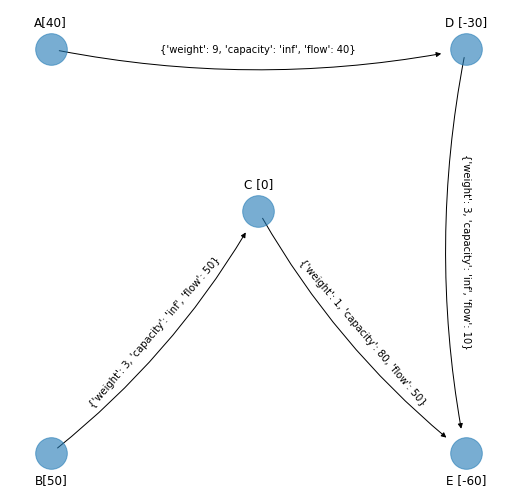

In [33]:
figsize_tuple = (9, 9)
plot_graph(figsize_tuple, G_simplex_spanning_tree_1,
           nodes_and_pos,
           nodes_and_pos_modified,
           node_labels_simplex_spanning_tree_1,
           edge_labels_simplex_spanning_tree_1)

Identificamos los arcos no básicos que son los que no están en el *spanning tree* solución factible que se obtuvo. En el margen se muestra la red de referencia y el *spanning tree* solución factible, entonces los arcos no básicos son: $(B,A), (A,C), (E,D)$. Recuérdese que el arco $(B,A)$ se representa con la variable $y_{AB}$. La idea es que al añadir un arco al *spanning tree* solución factible se obtendrá un ciclo no dirigido. En este ciclo no dirigido se realiza un análisis de cuál arco es el que tiene una tasa más alta de mejoramiento en la función objetivo.

**Arco $(B,A)$:**

In [34]:
edge_to_be_added_1 = ('B', 'A')

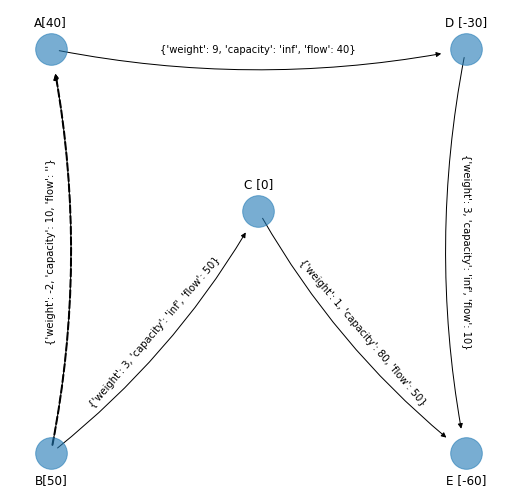

In [35]:
G_simplex_cycle_1, edge_labels_simplex_cycle_1 = add_edge_from_spanning_tree(G_simplex, G_simplex_spanning_tree_1, 
                                                                             edge_to_be_added_1,
                                                                             edge_labels_simplex_spanning_tree_1)
figsize_tuple = (9, 9)

plot_graph_with_cycle(figsize_tuple, G_simplex_cycle_1,
                      nodes_and_pos,
                      nodes_and_pos_modified,
                      node_labels_simplex_spanning_tree_1,
                      edge_labels_simplex_cycle_1,
                      edge_to_be_added_1)


```{margin}

Recordar la definición de {ref}`ciclo fundamental <CICLOFUND>`.

```

Entonces se forma un ciclo no dirigido. La orientación del ciclo se hereda de la dirección del arco añadido, en este caso en sentido de las manecillas del reloj:

In [36]:
cycle_1 = nx.find_cycle(G_simplex_cycle_1, source='B', orientation="ignore")

In [37]:
cycle_1_d = {(t[0], t[1]): t[2] for t in cycle_1}
fix_orientation(cycle_1_d, edge_to_be_added_1)
pprint.pprint(cycle_1_d)

{('A', 'D'): 'forward',
 ('B', 'A'): 'forward',
 ('B', 'C'): 'reverse',
 ('C', 'E'): 'reverse',
 ('D', 'E'): 'forward'}


Se calcula el costo unitario de incrementar el flujo por una unidad. Para los "forward" se suma y para los "reverse" se restan los costos:

In [38]:
edges_and_weights_simplex_cycle_1 = nx.get_edge_attributes(G_simplex_cycle_1, "weight")
pprint.pprint(edges_and_weights_simplex_cycle_1)

{('A', 'D'): 9, ('B', 'A'): -2, ('B', 'C'): 3, ('C', 'E'): 1, ('D', 'E'): 3}


In [39]:
print(np.sum(compute_cost_for_unit_increment(cycle_1_d, 
                                             edges_and_weights_simplex_cycle_1))
     )

6.0


**Arco $(A,C)$:**

In [40]:
edge_to_be_added_2 = ('A', 'C')

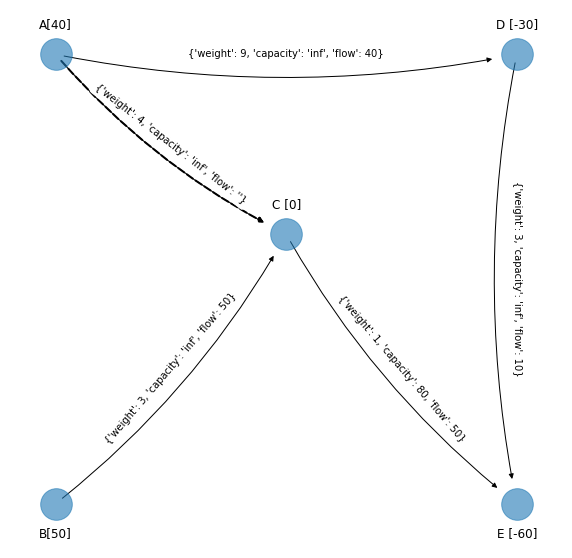

In [41]:
G_simplex_cycle_2, edge_labels_simplex_cycle_2 = add_edge_from_spanning_tree(G_simplex, G_simplex_spanning_tree_1, 
                                                                             edge_to_be_added_2,
                                                                             edge_labels_simplex_spanning_tree_1)

figsize_tuple = (10, 10)

plot_graph_with_cycle(figsize_tuple, G_simplex_cycle_2,
                      nodes_and_pos,
                      nodes_and_pos_modified,
                      node_labels_simplex_spanning_tree_1,
                      edge_labels_simplex_cycle_2,
                      edge_to_be_added_2)


In [42]:
cycle_2 = nx.find_cycle(G_simplex_cycle_2, source='B', orientation="ignore")

In [43]:
cycle_2_d = {(t[0], t[1]): t[2] for t in cycle_2}
fix_orientation(cycle_2_d, edge_to_be_added_2)
pprint.pprint(cycle_2_d)

{('A', 'C'): 'forward',
 ('A', 'D'): 'reverse',
 ('C', 'E'): 'forward',
 ('D', 'E'): 'reverse'}


Se calcula el costo unitario de incrementar el flujo por una unidad. Para los "forward" se suma y para los "reverse" se restan los costos:

In [44]:
edges_and_weights_simplex_cycle_2 = nx.get_edge_attributes(G_simplex_cycle_2, "weight")
pprint.pprint(edges_and_weights_simplex_cycle_2)

{('A', 'C'): 4, ('A', 'D'): 9, ('B', 'C'): 3, ('C', 'E'): 1, ('D', 'E'): 3}


In [45]:
print(np.sum(compute_cost_for_unit_increment(cycle_2_d, 
                                             edges_and_weights_simplex_cycle_2))
     )

-7.0


**Arco $(E,D)$:**

In [46]:
edge_to_be_added_3 = ('E', 'D')

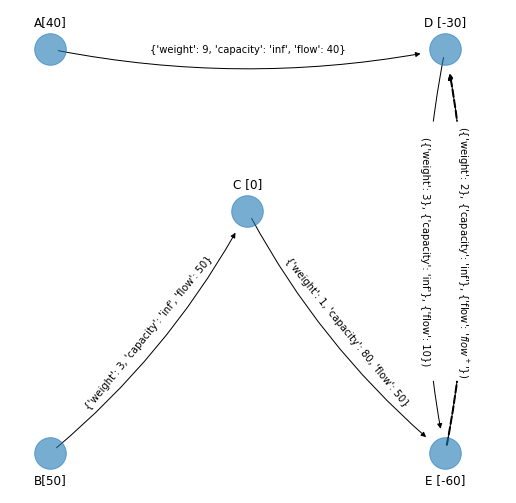

In [47]:
G_simplex_cycle_3, edge_labels_simplex_cycle_3 = add_edge_from_spanning_tree(G_simplex, G_simplex_spanning_tree_1, 
                                                                             edge_to_be_added_3,
                                                                             edge_labels_simplex_spanning_tree_1)

n1["flow"] = "$flow^+$"
n2["flow"] = G_simplex_spanning_tree_1['D']['E']["flow"]

stri1 = f'{({"weight": n1["weight"]},{"capacity": n1["capacity"]}, {"flow": n1["flow"]},)}'
stri2 = f'\n\n\n'
stri3 = f'{({"weight": n2["weight"]}, {"capacity": n2["capacity"]},{"flow": n2["flow"]})}'
string_for_edges_trouble_to_visualize = {('D', 'E'): ''.join([stri1, stri2, stri3])}

figsize_tuple = (9, 9)
plot_graph_with_cycle_edges_trouble_to_visualize(figsize_tuple,
                                                 G_simplex_cycle_3,
                                                 nodes_and_pos,
                                                 nodes_and_pos_modified,
                                                 node_labels_simplex_spanning_tree_1,
                                                 edge_labels_simplex_cycle_3,
                                                 edge_to_be_added_3,
                                                 string_for_edges_trouble_to_visualize
                                                 )

In [48]:
cycle_3 = nx.find_cycle(G_simplex_cycle_3, source='B', orientation="ignore")

In [49]:
cycle_3_d = {(t[0], t[1]): t[2] for t in cycle_3}
fix_orientation(cycle_3_d, edge_to_be_added_3)
pprint.pprint(cycle_3_d)

{('D', 'E'): 'forward', ('E', 'D'): 'forward'}


Se calcula el costo unitario de incrementar el flujo por una unidad. Para los "forward" se suma y para los "reverse" se restan los costos:

In [50]:
edges_and_weights_simplex_cycle_3 = nx.get_edge_attributes(G_simplex_cycle_3, "weight")
pprint.pprint(edges_and_weights_simplex_cycle_3)

{('A', 'D'): 9, ('B', 'C'): 3, ('C', 'E'): 1, ('D', 'E'): 3, ('E', 'D'): 2}


In [51]:
print(np.sum(compute_cost_for_unit_increment(cycle_3_d, 
                                             edges_and_weights_simplex_cycle_3))
     )

5.0


En resúmen:

|Arco | Costo por incrementar una unidad del arco|
|:---:|:---:|
|(B,A)|6|
|(A,C)|-7|
|(E,D)|5|

Entonces el arco no básico que tiene la tasa más alta de mejoramiento de $f_o$ es $(A,C)$.

```{admonition} Comentario

Si no hay arcos no básicos que mejoren $f_o$ entonces la solución actual es óptima.

```

In [52]:
print(edge_to_be_added_2)

('A', 'C')


### Revisión de cuál arco básico es sustituido

Tomando la red que resultó de añadir el arco no básico al *spanning tree* solución factible, la revisión de cuál arco básico es sustituido se determina incrementando el flujo de la red lo más posible hasta que uno de los arcos básicos llege a su cota inferior o superior. Denotemos al incremento como la cantidad $\text{flow}^+$ y para los arcos que son "forward" se suma tal cantidad al flujo actual y para los que son "reverse" se resta:

In [53]:
edge_labels_simplex_cycle_2_with_flow_change = edge_label_change_for_basic_edge_subs(cycle_2_d, 
                                                                                     edge_labels_simplex_cycle_2, 
                                                                                     edge_to_be_added_2)
pprint.pprint(edge_labels_simplex_cycle_2_with_flow_change)

{('A', 'C'): {'capacity': 'inf', 'flow': '$flow^+$', 'weight': 4},
 ('A', 'D'): {'bool': '-',
              'capacity': 'inf',
              'flow': '40- $flow^+$',
              'weight': 9},
 ('B', 'C'): {'bool': 0, 'capacity': 'inf', 'flow': 50, 'weight': 3},
 ('C', 'E'): {'bool': '+', 'capacity': 80, 'flow': '50+ $flow^+$', 'weight': 1},
 ('D', 'E'): {'bool': '-',
              'capacity': 'inf',
              'flow': '10- $flow^+$',
              'weight': 3}}


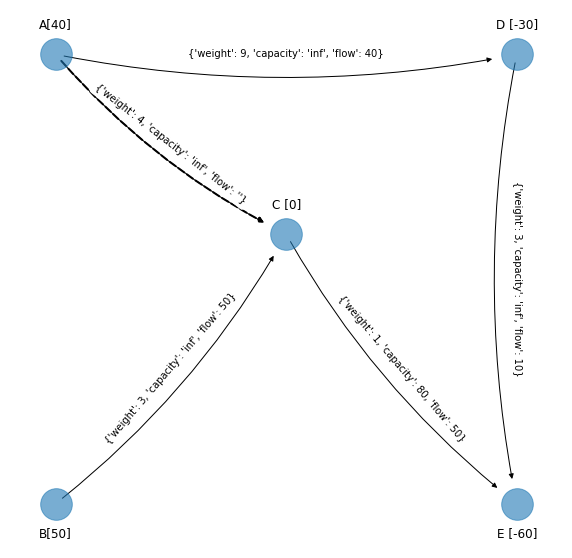

In [54]:
figsize_tuple = (10, 10)
plot_graph_with_cycle(figsize_tuple, G_simplex_cycle_2,
                      nodes_and_pos,
                      nodes_and_pos_modified,
                      node_labels_simplex_spanning_tree_1,
                      edge_labels_simplex_cycle_2,
                      edge_to_be_added_2)

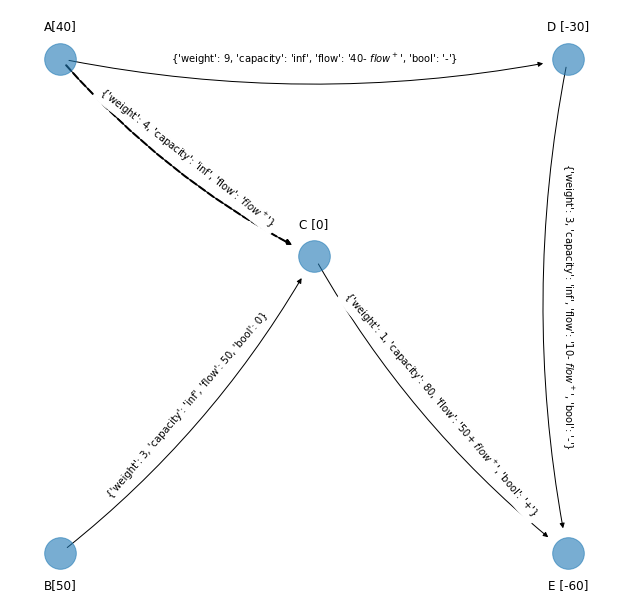

In [55]:
figsize_tuple = (11, 11)
plot_graph_with_cycle(figsize_tuple, G_simplex_cycle_2,
                      nodes_and_pos,
                      nodes_and_pos_modified,
                      node_labels_simplex_spanning_tree_1,
                      edge_labels_simplex_cycle_2_with_flow_change,
                      edge_to_be_added_2)

Como se debe cumplir la no negatividad y la cota superior, para los arcos en los que se aumenta y tienen cota superior se tiene

$$x_{CE} = 50 + \text{flow}^+ \leq 80$$

y para los arcos en los que se disminuye:

$$\begin{eqnarray}
x_{AD} = 40 - \text{flow}^+ &\geq& 0 \nonumber \\
x_{DE} = 10 - \text{flow}^+ &\geq& 0
\end{eqnarray}
$$

Por lo que:

$$\begin{eqnarray}
\text{flow}^+ &\leq& 30 \quad \text{que se obtuvo del arco } x_{CE} \nonumber \\
\text{flow}^+ &\leq& 40 \quad \text{que se obtuvo del arco } x_{AD} \nonumber \\
\text{flow}^+ &\leq& 10 \quad \text{que se obtuvo del arco } x_{DE} \nonumber
\end{eqnarray}
$$

El mínimo es $10$, entonces $\text{flow}^+ = 10$ y el arco básico que será sustituido es $(D,E)$. Como su flujo llega a cero **no** lo guardamos en la red `G_simplex_edges_upper_bounds`.

El nuevo *spanning tree* solución factible es:

In [56]:
flow_plus = 10

In [57]:
edge_to_remove_spanning_tree_2 = ('D', 'E')
edge_to_add_spanning_tree_2 = edge_to_be_added_2

In [58]:
print(edge_to_add_spanning_tree_2)

('A', 'C')


```{margin}

Se incrementa el flujo de la red únicamente en el ciclo por $\text{flow}^+ = 10$ y se elimina el arco $(D,E)$.

```

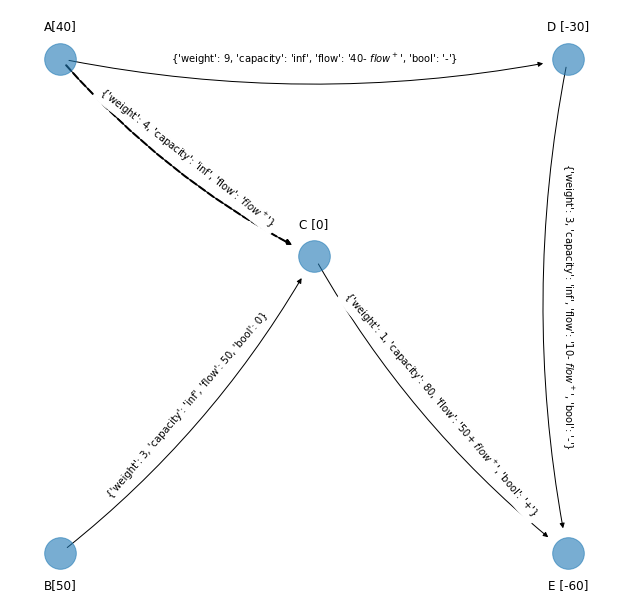

In [59]:
figsize_tuple = (11, 11)
plot_graph_with_cycle(figsize_tuple, G_simplex_cycle_2,
                      nodes_and_pos,
                      nodes_and_pos_modified,
                      node_labels_simplex_spanning_tree_1,
                      edge_labels_simplex_cycle_2_with_flow_change,
                      edge_to_be_added_2)

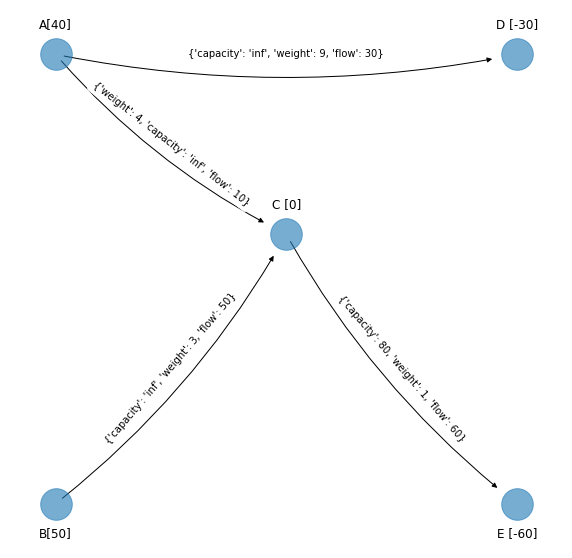

In [60]:
G_simplex_spanning_tree_2 = get_spanning_tree_from_spanning_tree_reference(G_simplex_spanning_tree_1, 
                                                                           edge_to_remove_spanning_tree_2,
                                                                           edge_to_add_spanning_tree_2)

G_simplex_spanning_tree_2, edge_labels_simplex_spanning_tree_2 = increase_flow_from_edge_labels_with_flow_change(G_simplex,
                                                                                                                 G_simplex_spanning_tree_1,
                                                                                                                 G_simplex_spanning_tree_2,
                                                                                                                 edge_to_add_spanning_tree_2,
                                                                                                                 edge_labels_simplex_cycle_2_with_flow_change)
node_labels_simplex_spanning_tree_2 = nx.get_node_attributes(G_simplex_spanning_tree_2, 
                                                            "node_and_netflow")
figsize_tuple = (10, 10)
plot_graph(figsize_tuple, G_simplex_spanning_tree_2,
           nodes_and_pos,
           nodes_and_pos_modified,
           node_labels_simplex_spanning_tree_2,
           edge_labels_simplex_spanning_tree_2)

## Iteración siguiente

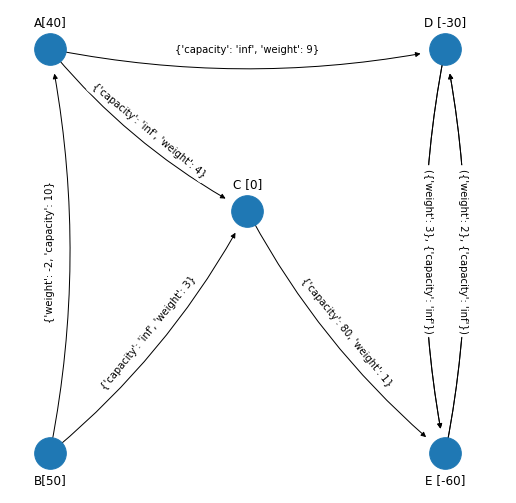

In [61]:
figsize_tuple = (9, 9)
plot_graph_with_edges_trouble_to_visualize(figsize_tuple,
                                           G_simplex, nodes_and_pos,
                                           nodes_and_pos_modified,
                                           node_labels_simplex,
                                           string_for_edges_trouble_to_visualize_simplex,
                                           list_of_edges_trouble_to_visualize_simplex)

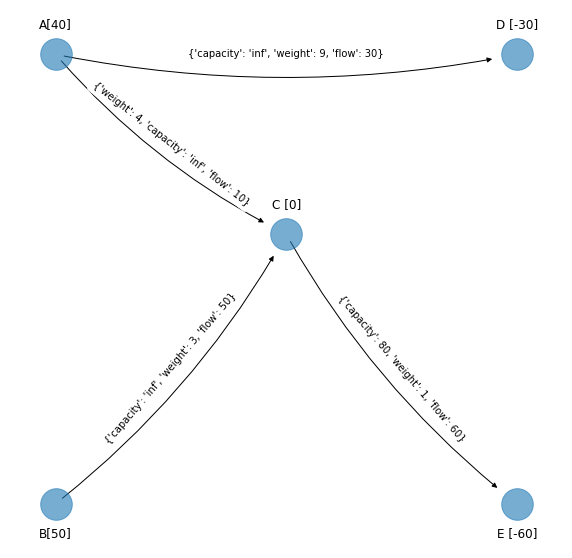

In [62]:
figsize_tuple = (10, 10)
plot_graph(figsize_tuple, G_simplex_spanning_tree_2,
           nodes_and_pos,
           nodes_and_pos_modified,
           node_labels_simplex_spanning_tree_2,
           edge_labels_simplex_spanning_tree_2)

Identificamos los arcos no básicos que son los que no están en el *spanning tree* solución factible que se obtuvo al final de la iteración anterior. En el margen se muestra la red de referencia y el *spanning tree* solución factible, entonces los arcos no básicos son $(B, A), (D, E), (E,D)$.

### Revisión de cuál arco no básico sustituye a un arco básico

**Arco $(B, A)$**:

In [63]:
edge_to_be_added_1 = ('B', 'A')

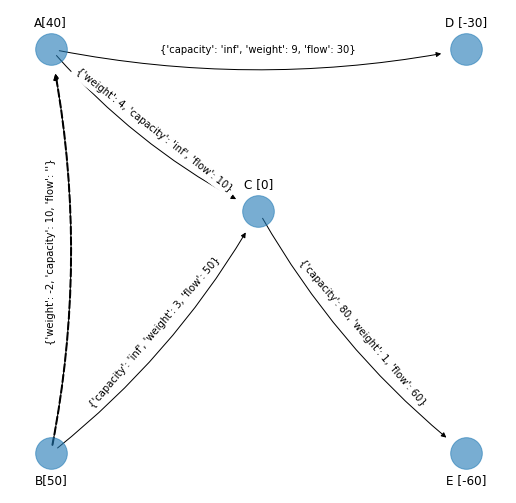

In [64]:
G_simplex_cycle_1, edge_labels_simplex_cycle_1 = add_edge_from_spanning_tree(G_simplex, G_simplex_spanning_tree_2, 
                                                                             edge_to_be_added_1,
                                                                             edge_labels_simplex_spanning_tree_2)

figsize_tuple = (9, 9)

plot_graph_with_cycle(figsize_tuple, G_simplex_cycle_1,
                      nodes_and_pos,
                      nodes_and_pos_modified,
                      node_labels_simplex_spanning_tree_2,
                      edge_labels_simplex_cycle_1,
                      edge_to_be_added_1)

```{margin}

Recordar la definición de {ref}`ciclo fundamental <CICLOFUND>`.

```

Entonces se forma un ciclo no dirigido. Se calcula el costo unitario de incrementar el flujo por una unidad. Para los arcos "forward" se suma y para los "reverse" se restan los costos:

In [65]:
cycle_1 = nx.find_cycle(G_simplex_cycle_1, source='B', orientation="ignore")
cycle_1_d = {(t[0], t[1]): t[2] for t in cycle_1}
fix_orientation(cycle_1_d, edge_to_be_added_1)

edges_and_weights_simplex_cycle_1 = nx.get_edge_attributes(G_simplex_cycle_1, "weight")

print(np.sum(compute_cost_for_unit_increment(cycle_1_d, 
                                             edges_and_weights_simplex_cycle_1))
     )

-1.0


**Arco $(D, E)$**:

In [66]:
edge_to_be_added_2 = ('D', 'E')

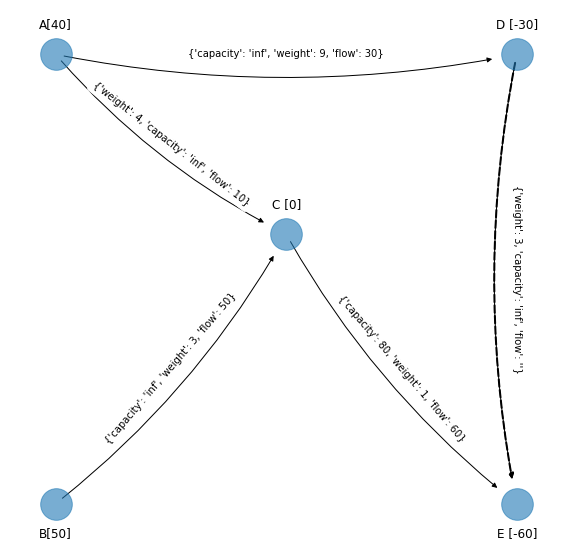

In [67]:
G_simplex_cycle_2, edge_labels_simplex_cycle_2 = add_edge_from_spanning_tree(G_simplex, G_simplex_spanning_tree_2, 
                                                                             edge_to_be_added_2,
                                                                             edge_labels_simplex_spanning_tree_2)

figsize_tuple = (10, 10)

plot_graph_with_cycle(figsize_tuple, G_simplex_cycle_2,
                      nodes_and_pos,
                      nodes_and_pos_modified,
                      node_labels_simplex_spanning_tree_2,
                      edge_labels_simplex_cycle_2,
                      edge_to_be_added_2)

Entonces se forma un ciclo no dirigido. Se calcula el costo unitario de incrementar el flujo por una unidad. Para los arcos "forward" se suma y para los "reverse" se restan los costos:

In [68]:
cycle_2 = nx.find_cycle(G_simplex_cycle_2, source='B', orientation="ignore")
cycle_2_d = {(t[0], t[1]): t[2] for t in cycle_2}
fix_orientation(cycle_2_d, edge_to_be_added_2)

edges_and_weights_simplex_cycle_2 = nx.get_edge_attributes(G_simplex_cycle_2, "weight")

print(np.sum(compute_cost_for_unit_increment(cycle_2_d, 
                                             edges_and_weights_simplex_cycle_2))
     )

7.0


**Arco $(E, D)$**:

In [69]:
edge_to_be_added_3 = ('E', 'D')

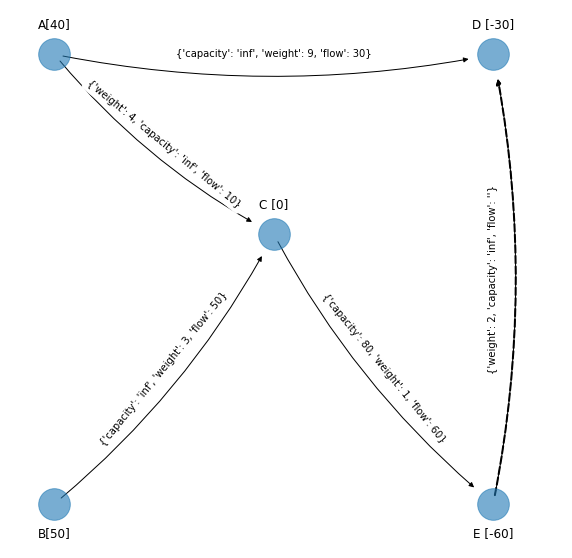

In [70]:
G_simplex_cycle_3, edge_labels_simplex_cycle_3 = add_edge_from_spanning_tree(G_simplex, G_simplex_spanning_tree_2, 
                                                                             edge_to_be_added_3,
                                                                             edge_labels_simplex_spanning_tree_2)

figsize_tuple = (10, 10)

plot_graph_with_cycle(figsize_tuple, G_simplex_cycle_3,
                      nodes_and_pos,
                      nodes_and_pos_modified,
                      node_labels_simplex_spanning_tree_2,
                      edge_labels_simplex_cycle_3,
                      edge_to_be_added_3)

Entonces se forma un ciclo no dirigido. Se calcula el costo unitario de incrementar el flujo por una unidad. Para los arcos "forward" se suma y para los "reverse" se restan los costos:

In [71]:
cycle_3 = nx.find_cycle(G_simplex_cycle_3, source='B', orientation="ignore")
cycle_3_d = {(t[0], t[1]): t[2] for t in cycle_3}
fix_orientation(cycle_3_d, edge_to_be_added_3)

edges_and_weights_simplex_cycle_3 = nx.get_edge_attributes(G_simplex_cycle_3, "weight")

print(np.sum(compute_cost_for_unit_increment(cycle_3_d, 
                                             edges_and_weights_simplex_cycle_3))
     )

-2.0


En resúmen:

|Arco | Costo por incrementar una unidad del arco|
|:---:|:---:|
|(B,A)|-1|
|(D,E)|7|
|(E,D)|-2|

Entonces el arco no básico que tiene la tasa más alta de mejoramiento de $f_o$ es $(E,D)$.

```{margin}

Si no hay arcos no básicos que mejoren $f_o$ entonces la solución actual es óptima.

```

In [72]:
print(edge_to_be_added_3)

('E', 'D')


### Revisión de cuál arco básico es sustituido

Tomando la red que resultó de añadir el arco no básico al *spanning tree* solución factible, se determina incrementando el flujo de la red lo más posible hasta que uno de los arcos básicos llege a su cota inferior o superior. 
Se denota como la cantidad $flow^+$ y para los arcos que son "forward" se suma tal cantidad al flujo actual y para los que son "reverse" se resta:

In [73]:
edge_labels_simplex_cycle_3_with_flow_change = edge_label_change_for_basic_edge_subs(cycle_3_d, 
                                                                                     edge_labels_simplex_cycle_3, 
                                                                                     edge_to_be_added_3)
pprint.pprint(edge_labels_simplex_cycle_3_with_flow_change)

{('A', 'C'): {'bool': '+',
              'capacity': 'inf',
              'flow': '10+ $flow^+$',
              'weight': 4},
 ('A', 'D'): {'bool': '-',
              'capacity': 'inf',
              'flow': '30- $flow^+$',
              'weight': 9},
 ('B', 'C'): {'bool': 0, 'capacity': 'inf', 'flow': 50, 'weight': 3},
 ('C', 'E'): {'bool': '+', 'capacity': 80, 'flow': '60+ $flow^+$', 'weight': 1},
 ('E', 'D'): {'capacity': 'inf', 'flow': '$flow^+$', 'weight': 2}}


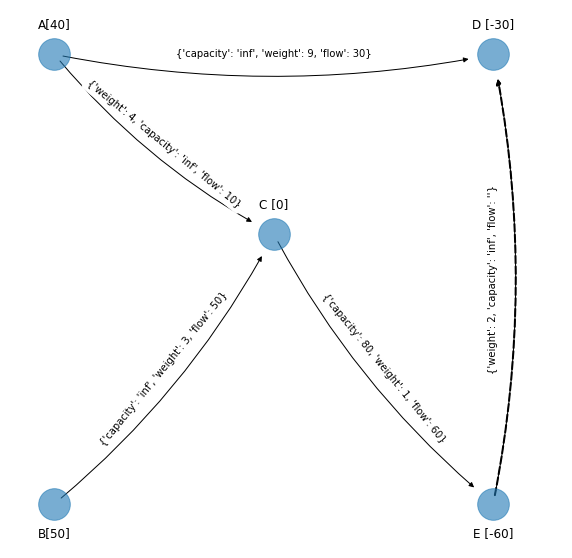

In [74]:
figsize_tuple = (10, 10)

plot_graph_with_cycle(figsize_tuple, G_simplex_cycle_3,
                      nodes_and_pos,
                      nodes_and_pos_modified,
                      node_labels_simplex_spanning_tree_2,
                      edge_labels_simplex_cycle_3,
                      edge_to_be_added_3)

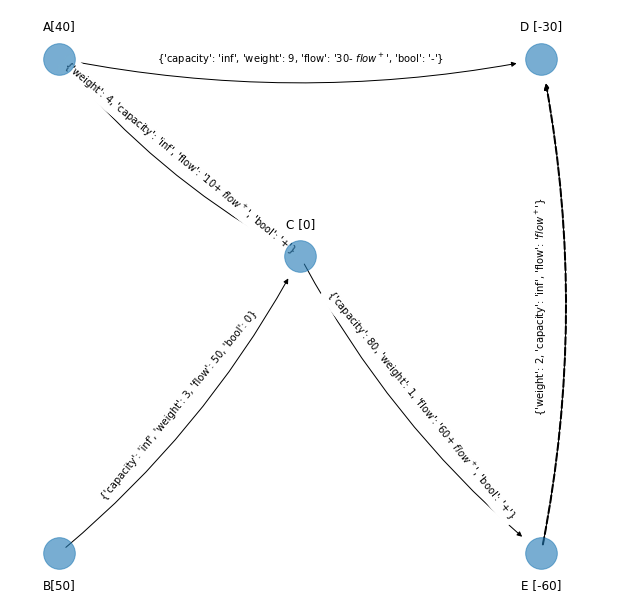

In [75]:
figsize_tuple = (11, 11)
plot_graph_with_cycle(figsize_tuple, G_simplex_cycle_3,
                      nodes_and_pos,
                      nodes_and_pos_modified,
                      node_labels_simplex_spanning_tree_2,
                      edge_labels_simplex_cycle_3_with_flow_change,
                      edge_to_be_added_3)

Como se debe cumplir la no negatividad y la cota superior, para los arcos en los que se aumenta y tienen cota superior se tiene:

$$
x_{CE} = 60 + \text{flow}^+ \leq 80
$$

y para los arcos en los que se disminuye:

$$
x_{AD} = 30 - \text{flow}^+ \geq 0
$$

Por lo que:

$$
\begin{eqnarray}
\text{flow}^+ &\leq& 20 \quad \text{que se obtuvo del arco } x_{CE} \nonumber \\
\text{flow}^+ &\leq& 30 \quad \text{que se obtuvo del arco } x_{AD} \nonumber \\
\end{eqnarray}
$$

El mínimo es 20, entonces $\text{flow}^+=20$ y el arco básico que será sustituido es $(C,E)$.

### Técnica de la cota superior

Al modificar el flujo con $\text{flow}^+=20$ se tiene que el arco $(C,E)$ tiene un flujo igual a $80$ con lo que llegó a su capacidad máxima. Entonces se intercambia el arco $(C, E)$ por el arco $(E, C)$ con costo unitario igual al negativo de $(C, E)$, misma capacidad y con flujo igual igual $0$. Surge una nueva variable no básica $y_{CE} = 0$ y $x_{CE} = 80 - y_{CE}$. $b_E$ se le aumenta $80$ y $b_C$ se le resta $80$:


In [76]:
edge_to_remove_from_network = ('C', 'E')
edge_to_add_new_network = ('E', 'C')


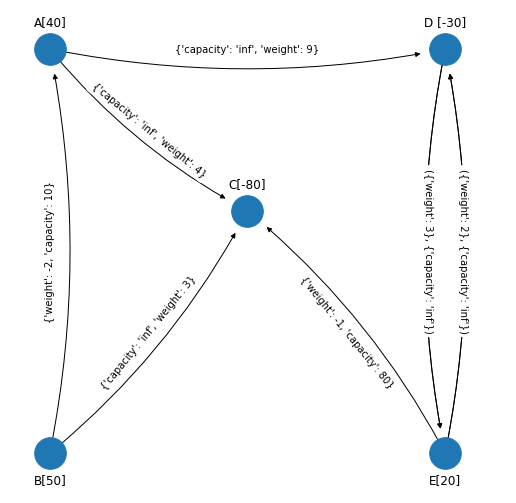

In [77]:
G_simplex2,edge_labels_simplex2 = get_new_network_after_upper_bound_technique(G_simplex, edge_to_remove_from_network,
                                                                              edge_to_add_new_network)

node_labels_simplex = nx.get_node_attributes(G_simplex2, "node_and_netflow")

string_for_edges_trouble_to_visualize_simplex = string_for_edges_trouble_to_visualize_min_cost_flow

list_of_edges_trouble_to_visualize_simplex = list_of_edges_trouble_to_visualize_min_cost_flow


node_labels_simplex2 = nx.get_node_attributes(G_simplex2, "node_and_netflow")

figsize_tuple = (9, 9)
plot_graph_with_edges_trouble_to_visualize(figsize_tuple,
                                           G_simplex2, nodes_and_pos,
                                           nodes_and_pos_modified,
                                           node_labels_simplex2,
                                           string_for_edges_trouble_to_visualize_simplex,
                                           list_of_edges_trouble_to_visualize_simplex)

Para futura referencia el arco $(C,E)$ que alcanzó la cota superior lo guardamos en la red `G_simplex_edges_upper_bounds`.

In [78]:
edge_to_be_added_in_graph_of_upper_bounds = ('C','E')

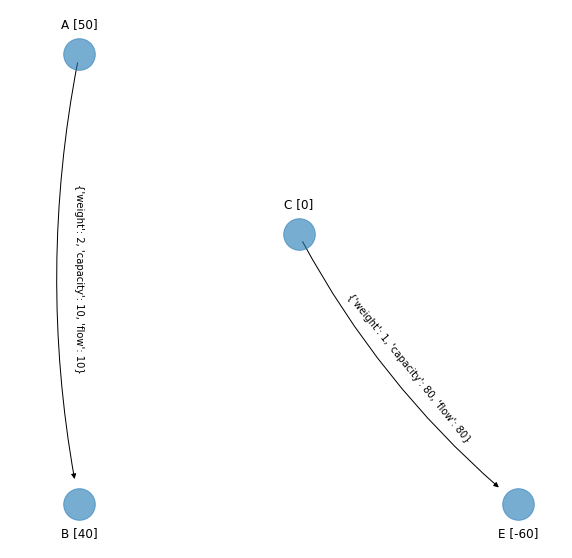

In [79]:
G_simplex_edges_upper_bounds.add_node(edge_to_be_added_in_graph_of_upper_bounds[0])
G_simplex_edges_upper_bounds.add_node(edge_to_be_added_in_graph_of_upper_bounds[1])

G_simplex_edges_upper_bounds = add_edge_to_graph_of_upper_bounds(G_min_cost_flow,
                                                                 G_simplex_edges_upper_bounds,
                                                                 edge_to_be_added_in_graph_of_upper_bounds,
                                                                 edge_labels_simplex_upper_bounds)

node_labels_simplex_upper_bounds = nx.get_node_attributes(G_simplex_edges_upper_bounds, "node_and_netflow")

figsize_tuple = (10, 10)
plot_graph(figsize_tuple, G_simplex_edges_upper_bounds,
           nodes_and_pos,
           nodes_and_pos_modified,
           node_labels_simplex_upper_bounds,
           edge_labels_simplex_upper_bounds)

El nuevo *spanning tree* factible es:

In [80]:
flow_plus = 20

In [81]:
edge_to_remove_spanning_tree_3 = ('C', 'E')
edge_to_add_spanning_tree_3 = edge_to_be_added_3

In [82]:
print(edge_to_add_spanning_tree_3)

('E', 'D')


```{margin}

Se incrementa el flujo de la red únicamente en el ciclo por $\text{flow}^+ = 20$ y se elimina el arco $(C,E)$.

```

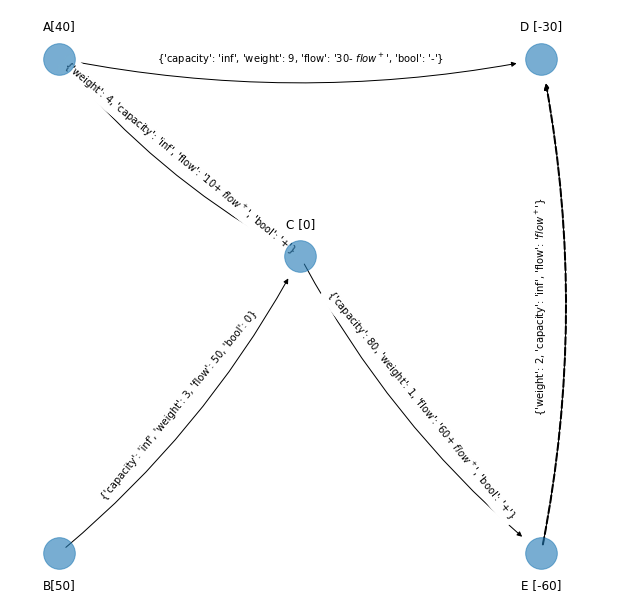

In [83]:
figsize_tuple = (11, 11)
plot_graph_with_cycle(figsize_tuple, G_simplex_cycle_3,
                      nodes_and_pos,
                      nodes_and_pos_modified,
                      node_labels_simplex_spanning_tree_2,
                      edge_labels_simplex_cycle_3_with_flow_change,
                      edge_to_be_added_3)

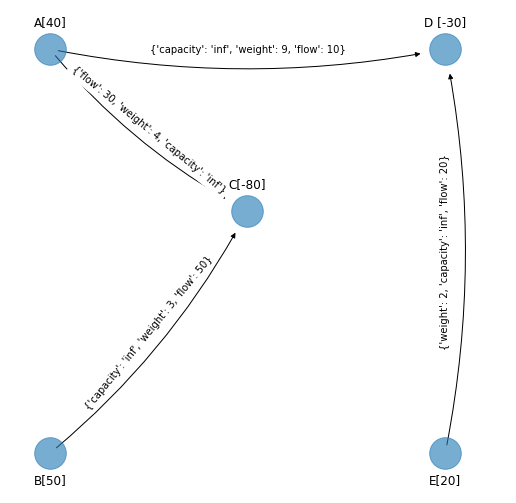

In [84]:
G_simplex_spanning_tree_3 = get_spanning_tree_from_spanning_tree_reference(G_simplex_spanning_tree_2, 
                                                                           edge_to_remove_spanning_tree_3,
                                                                           edge_to_add_spanning_tree_3)

G_simplex_spanning_tree_3, edge_labels_simplex_spanning_tree_3 = increase_flow_from_edge_labels_with_flow_change(G_simplex2,
                                                                                                                 G_simplex_spanning_tree_2,
                                                                                                                 G_simplex_spanning_tree_3,
                                                                                                                 edge_to_add_spanning_tree_3,
                                                                                                                 edge_labels_simplex_cycle_3_with_flow_change)
value_capacity = G_simplex[edge_to_remove_from_network[0]][edge_to_remove_from_network[1]]["capacity"]
update_netflows_after_upper_bound_technique(G_simplex_spanning_tree_3,
                                            value_capacity,
                                            edge_to_remove_from_network)
node_labels_simplex_spanning_tree_3 = nx.get_node_attributes(G_simplex_spanning_tree_3, 
                                                            "node_and_netflow")
figsize_tuple = (9, 9)
plot_graph(figsize_tuple, G_simplex_spanning_tree_3,
           nodes_and_pos,
           nodes_and_pos_modified,
           node_labels_simplex_spanning_tree_3,
           edge_labels_simplex_spanning_tree_3)

## Iteración siguiente

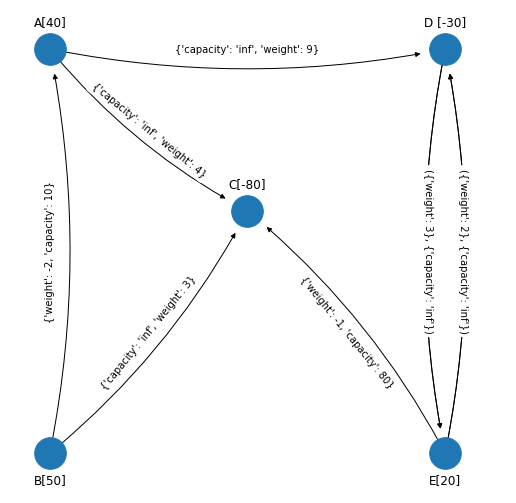

In [85]:
figsize_tuple = (9, 9)
plot_graph_with_edges_trouble_to_visualize(figsize_tuple,
                                           G_simplex2, nodes_and_pos,
                                           nodes_and_pos_modified,
                                           node_labels_simplex2,
                                           string_for_edges_trouble_to_visualize_simplex,
                                           list_of_edges_trouble_to_visualize_simplex)

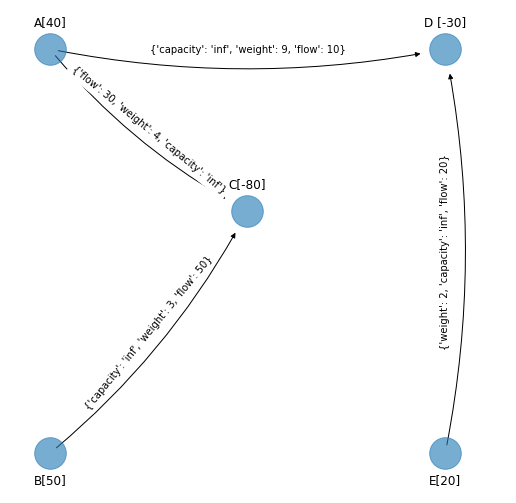

In [86]:
figsize_tuple = (9, 9)
plot_graph(figsize_tuple, G_simplex_spanning_tree_3,
           nodes_and_pos,
           nodes_and_pos_modified,
           node_labels_simplex_spanning_tree_3,
           edge_labels_simplex_spanning_tree_3)

Identificamos los arcos no básicos que son los que no están en el *spanning tree* solución factible que se obtuvo al final de la iteración anterior. En el margen se muestra la red y el *spanning tree* solución factible, entonces los arcos no básicos son $(B,A), (E,C), (D,E)$.

### Revisión de cuál arco no básico sustituye a un arco básico

**Arco $(B, A)$**

In [87]:
edge_to_be_added_1 = ('B', 'A')

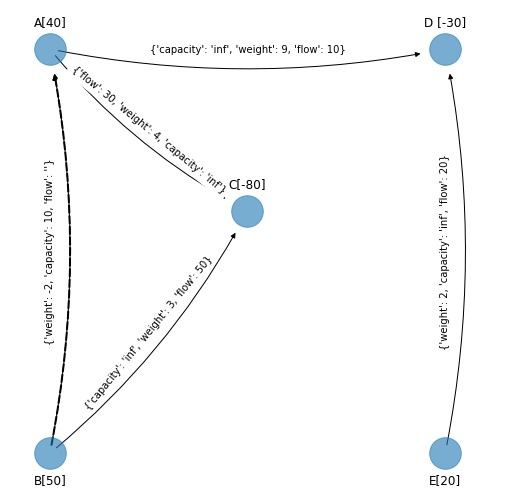

In [88]:
G_simplex_cycle_1, edge_labels_simplex_cycle_1 = add_edge_from_spanning_tree(G_simplex2, G_simplex_spanning_tree_3, 
                                                                             edge_to_be_added_1,
                                                                             edge_labels_simplex_spanning_tree_3)


figsize_tuple = (9, 9)

plot_graph_with_cycle(figsize_tuple, G_simplex_cycle_1,
                      nodes_and_pos,
                      nodes_and_pos_modified,
                      node_labels_simplex_spanning_tree_3,
                      edge_labels_simplex_cycle_1,
                      edge_to_be_added_1)

In [89]:
cycle_1 = nx.find_cycle(G_simplex_cycle_1, source='B', orientation="ignore")
cycle_1_d = {(t[0], t[1]): t[2] for t in cycle_1}
fix_orientation(cycle_1_d, edge_to_be_added_1)

edges_and_weights_simplex_cycle_1 = nx.get_edge_attributes(G_simplex_cycle_1, "weight")

print(np.sum(compute_cost_for_unit_increment(cycle_1_d, 
                                             edges_and_weights_simplex_cycle_1))
     )

-1.0


**Arco $(E, C)$**

In [90]:
edge_to_be_added_2 = ('E', 'C')

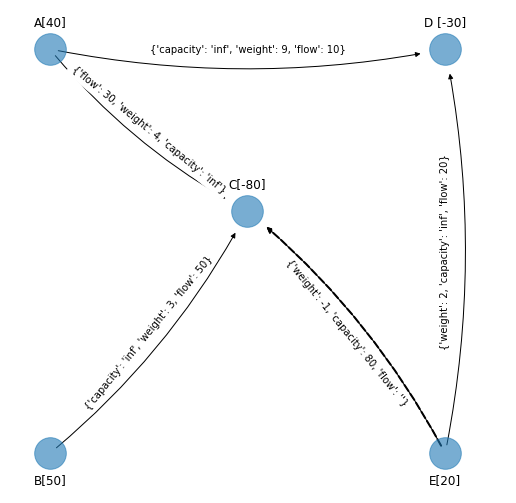

In [91]:
G_simplex_cycle_2, edge_labels_simplex_cycle_2 = add_edge_from_spanning_tree(G_simplex2, G_simplex_spanning_tree_3, 
                                                                             edge_to_be_added_2,
                                                                             edge_labels_simplex_spanning_tree_3)

figsize_tuple = (9, 9)

plot_graph_with_cycle(figsize_tuple, G_simplex_cycle_2,
                      nodes_and_pos,
                      nodes_and_pos_modified,
                      node_labels_simplex_spanning_tree_3,
                      edge_labels_simplex_cycle_2,
                      edge_to_be_added_2)

In [92]:
cycle_2 = nx.find_cycle(G_simplex_cycle_2, source='B', orientation="ignore")
cycle_2_d = {(t[0], t[1]): t[2] for t in cycle_2}
fix_orientation(cycle_2_d, edge_to_be_added_2)

edges_and_weights_simplex_cycle_2 = nx.get_edge_attributes(G_simplex_cycle_2, "weight")

print(np.sum(compute_cost_for_unit_increment(cycle_2_d, 
                                             edges_and_weights_simplex_cycle_2))
     )

2.0


**Arco $(D, E)$**

In [93]:
edge_to_be_added_3 = ('D', 'E')

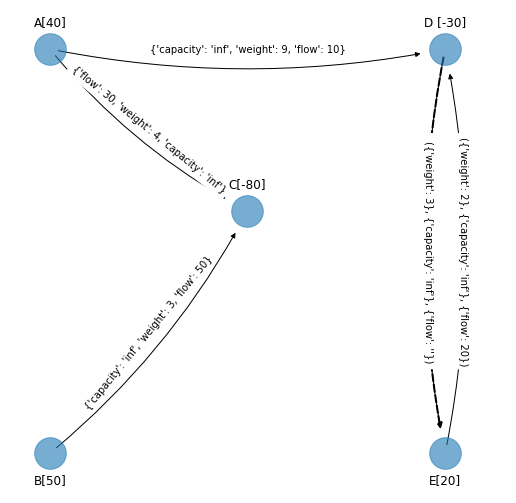

In [94]:
G_simplex_cycle_3, edge_labels_simplex_cycle_3 = add_edge_from_spanning_tree(G_simplex2, G_simplex_spanning_tree_3, 
                                                                             edge_to_be_added_3,
                                                                             edge_labels_simplex_spanning_tree_3)


n1["flow"] = G_simplex_spanning_tree_3['E']['D']["flow"]
n2["flow"] = ""


stri1 = f'{({"weight": n1["weight"]},{"capacity": n1["capacity"]}, {"flow": n1["flow"]},)}'
stri2 = f'\n\n\n'
stri3 = f'{({"weight": n2["weight"]}, {"capacity": n2["capacity"]},{"flow": n2["flow"]})}'
string_for_edges_trouble_to_visualize = {('D', 'E'): ''.join([stri1, stri2, stri3])}

figsize_tuple = (9, 9)
plot_graph_with_cycle_edges_trouble_to_visualize(figsize_tuple,
                                                 G_simplex_cycle_3,
                                                 nodes_and_pos,
                                                 nodes_and_pos_modified,
                                                 node_labels_simplex_spanning_tree_3,
                                                 edge_labels_simplex_cycle_3,
                                                 edge_to_be_added_3,
                                                 string_for_edges_trouble_to_visualize
                                                 )

In [95]:
cycle_3 = nx.find_cycle(G_simplex_cycle_3, source='B', orientation="ignore")
cycle_3_d = {(t[0], t[1]): t[2] for t in cycle_3}
fix_orientation(cycle_3_d, edge_to_be_added_3)

edges_and_weights_simplex_cycle_3 = nx.get_edge_attributes(G_simplex_cycle_3, "weight")

print(np.sum(compute_cost_for_unit_increment(cycle_3_d, 
                                             edges_and_weights_simplex_cycle_3))
     )

5.0


En resúmen:

|Arco | Costo por incrementar una unidad del arco|
|:---:|:---:|
|(B,A)|-1|
|(E,C)|2|
|(D,E)|5|

Entonces el arco no básico que tiene la tasa más alta de mejoramiento de $f_o$ es $(B,A)$.

```{margin}

Si no hay arcos no básicos que mejoren $f_o$ entonces la solución actual es óptima.

```

In [96]:
print(edge_to_be_added_1)

('B', 'A')


### Revisión de cuál arco básico es sustituido

Se denota como la cantidad $\text{flow}^+$ y para los arcos que son "forward" se suma tal cantidad al flujo actual y para los que son "reverse" se resta:

In [97]:
edge_labels_simplex_cycle_1_with_flow_change = edge_label_change_for_basic_edge_subs(cycle_1_d, 
                                                                                     edge_labels_simplex_cycle_1,
                                                                                     edge_to_be_added_1)
pprint.pprint(edge_labels_simplex_cycle_1_with_flow_change)

{('A', 'C'): {'bool': '+',
              'capacity': 'inf',
              'flow': '30+ $flow^+$',
              'weight': 4},
 ('A', 'D'): {'bool': 0, 'capacity': 'inf', 'flow': 10, 'weight': 9},
 ('B', 'A'): {'capacity': 10, 'flow': '$flow^+$', 'weight': -2},
 ('B', 'C'): {'bool': '-',
              'capacity': 'inf',
              'flow': '50- $flow^+$',
              'weight': 3},
 ('E', 'D'): {'bool': 0, 'capacity': 'inf', 'flow': 20, 'weight': 2}}


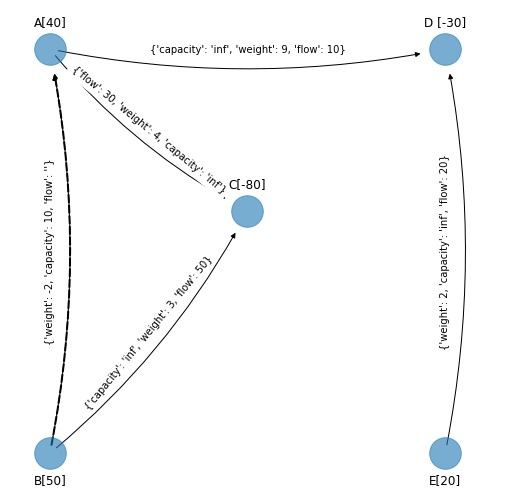

In [98]:
figsize_tuple = (9, 9)

plot_graph_with_cycle(figsize_tuple, G_simplex_cycle_1,
                      nodes_and_pos,
                      nodes_and_pos_modified,
                      node_labels_simplex_spanning_tree_3,
                      edge_labels_simplex_cycle_1,
                      edge_to_be_added_1)

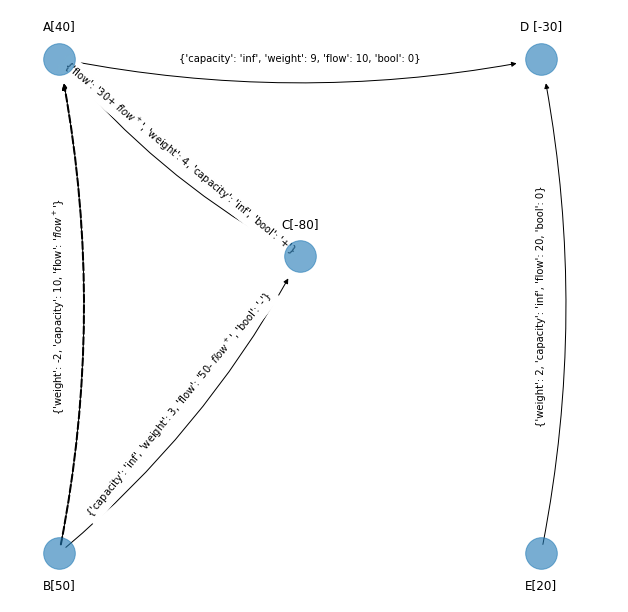

In [99]:
figsize_tuple = (11, 11)
plot_graph_with_cycle(figsize_tuple, G_simplex_cycle_1,
                      nodes_and_pos,
                      nodes_and_pos_modified,
                      node_labels_simplex_spanning_tree_3,
                      edge_labels_simplex_cycle_1_with_flow_change,
                      edge_to_be_added_1)

Como se debe cumplir la no negatividad y la cota superior, para los arcos en los que se aumenta y tienen cota superior se tiene:

$$y_{AB} = \text{flow}^+ \leq 10$$

y para los arcos en los que se disminuye:

$$x_{BC} = 50 - \text{flow}^+ \geq 0$$

Por lo que:

$$
\begin{eqnarray}
\text{flow}^+ \leq 10 \quad \text{que se obtuvo del arco } y_{AB} \nonumber \\
\text{flow}^+ \leq 50 \quad \text{que se obtuvo del arco } x_{BC} 
\end{eqnarray}
$$

El mínimo es $10$, entonces $\text{flow}^+=10$ y el arco que será sustituido es $(B, A)$.

### Técnica de la cota superior

Al modificar el flujo con $\text{flow}^+=10$ se tiene que el arco $(B,A)$ tiene un flujo igual a $10$ con lo que llegó a su capacidad máxima. Entonces se intercambia el arco $(B,A)$ por el arco $(A,B)$ con costo unitario igual al negativo de $(B,A)$, misma capacidad y con flujo igual igual 0. Las asignaciones en las variables son $y_{AB}=10$ y $x_{AB} = 10 - y_{AB} = 10 - 10 = 0$. $b_A$ se le aumenta $10$ y $b_B$ se le resta $10$. 

```{admonition} Comentario

Una variable nueva que se haya añadido por la técnica de la cota superior que alcance un valor igual a su capacidad puede eliminarse. En este caso $y_{AB} = 10$ por lo que alcanzó un flujo igual a su capacidad y puede eliminarse.

```

In [100]:
edge_to_remove_from_network = ('B', 'A')
edge_to_add_new_network = ('A', 'B')


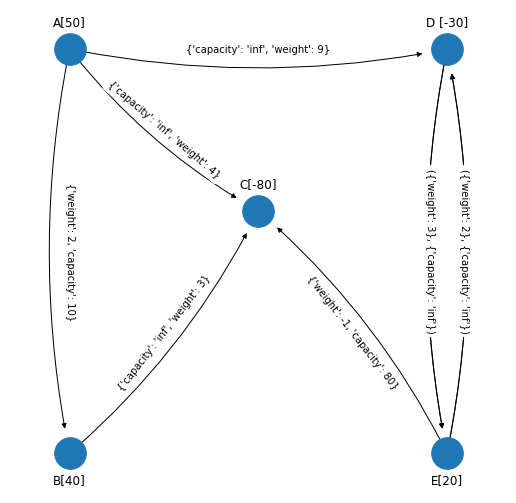

In [101]:
G_simplex3,edge_labels_simplex3 = get_new_network_after_upper_bound_technique(G_simplex2, edge_to_remove_from_network,
                                                                              edge_to_add_new_network)

node_labels_simplex = nx.get_node_attributes(G_simplex3, "node_and_netflow")

string_for_edges_trouble_to_visualize_simplex = string_for_edges_trouble_to_visualize_min_cost_flow

list_of_edges_trouble_to_visualize_simplex = list_of_edges_trouble_to_visualize_min_cost_flow


node_labels_simplex3 = nx.get_node_attributes(G_simplex3, "node_and_netflow")

figsize_tuple = (9, 9)
plot_graph_with_edges_trouble_to_visualize(figsize_tuple,
                                           G_simplex3, nodes_and_pos,
                                           nodes_and_pos_modified,
                                           node_labels_simplex3,
                                           string_for_edges_trouble_to_visualize_simplex,
                                           list_of_edges_trouble_to_visualize_simplex)

**También recuérdese que el arco $(A, B)$ tenía flujo $x_{AB}$ igual a su capacidad**:

In [102]:
print(G_simplex_edges_upper_bounds['A']['B']["flow"])

10


Como el arco $(A,B)$ después de la actualización ahora tiene un flujo igual a cero se quita de la red `G_simplex_edges_upper_bounds`



In [103]:
edge_to_be_removed_in_graph_of_upper_bounds = ('A','B')
G_simplex_edges_upper_bounds.remove_edge(edge_to_be_removed_in_graph_of_upper_bounds[0],
                                         edge_to_be_removed_in_graph_of_upper_bounds[1])
G_simplex_edges_upper_bounds.remove_node(edge_to_be_removed_in_graph_of_upper_bounds[0])
G_simplex_edges_upper_bounds.remove_node(edge_to_be_removed_in_graph_of_upper_bounds[1])
edge_labels_simplex_upper_bounds.pop(edge_to_be_removed_in_graph_of_upper_bounds, None)

{'weight': 2, 'capacity': 10, 'flow': 10}

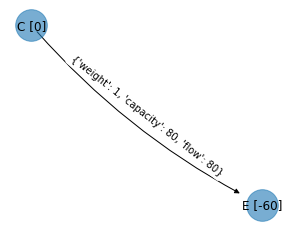

In [104]:
node_labels_simplex_upper_bounds = nx.get_node_attributes(G_simplex_edges_upper_bounds, "node_and_netflow")

figsize_tuple = (5, 4)
plot_graph(figsize_tuple, G_simplex_edges_upper_bounds,
           nodes_and_pos,
           nodes_and_pos,
           node_labels_simplex_upper_bounds,
           edge_labels_simplex_upper_bounds)

```{margin}

*Spanning tree* solución factible anterior dado que el arco que entra es el mismo que sale.

```

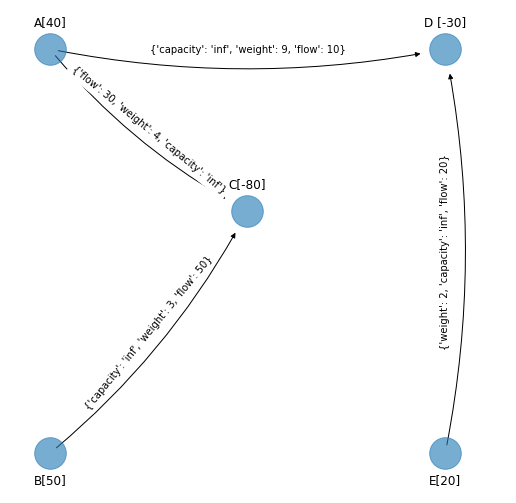

In [105]:
figsize_tuple = (9, 9)
plot_graph(figsize_tuple, G_simplex_spanning_tree_3,
           nodes_and_pos,
           nodes_and_pos_modified,
           node_labels_simplex_spanning_tree_3,
           edge_labels_simplex_spanning_tree_3)

In [106]:
flow_plus = 10

In [107]:
edge_to_remove_spanning_tree_4 = ('B', 'A')
edge_to_add_spanning_tree_4 = edge_to_be_added_1

In [108]:
print(edge_to_add_spanning_tree_4)

('B', 'A')


Como el arco que entra es el mismo que sale ... sólo se incrementa el flujo de acuerdo al análisis previo para el *spanning tree* solución factible anterior el cual se muestra en el margen.

```{margin}

Se incrementa el flujo de la red únicamente en el ciclo por $\text{flow}^+ = 10$ y se elimina el arco $(B,A)$.

```

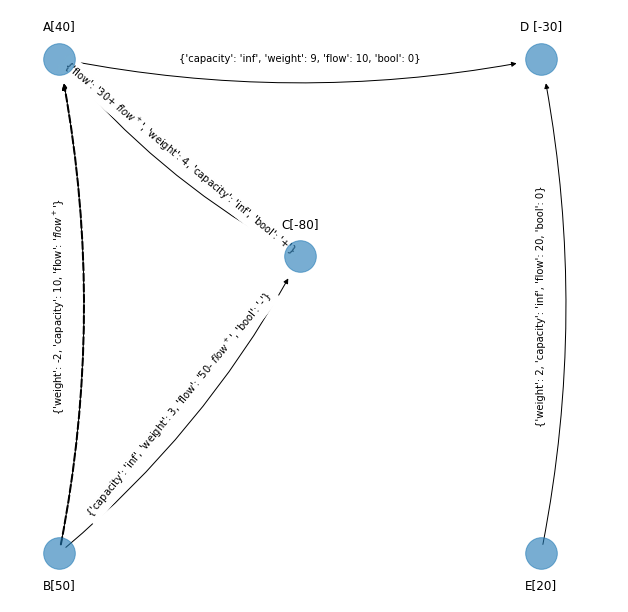

In [109]:
figsize_tuple = (11, 11)
plot_graph_with_cycle(figsize_tuple, G_simplex_cycle_1,
                      nodes_and_pos,
                      nodes_and_pos_modified,
                      node_labels_simplex_spanning_tree_3,
                      edge_labels_simplex_cycle_1_with_flow_change,
                      edge_to_be_added_1)

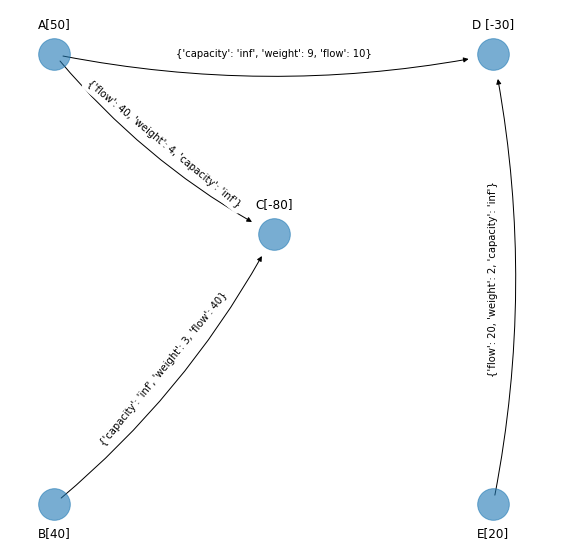

In [110]:
G_simplex_spanning_tree_4 = G_simplex_spanning_tree_3.copy()

G_simplex_spanning_tree_4, edge_labels_simplex_spanning_tree_4 = increase_flow_from_edge_labels_with_flow_change(G_simplex3,
                                                                                                                 G_simplex_spanning_tree_3,
                                                                                                                 G_simplex_spanning_tree_4,
                                                                                                                 edge_to_add_spanning_tree_4,
                                                                                                                 edge_labels_simplex_cycle_1_with_flow_change)

value_capacity = G_simplex[edge_to_remove_from_network[0]][edge_to_remove_from_network[1]]["capacity"]
update_netflows_after_upper_bound_technique(G_simplex_spanning_tree_4,
                                            value_capacity,
                                            edge_to_remove_from_network)

node_labels_simplex_spanning_tree_4 = nx.get_node_attributes(G_simplex_spanning_tree_4, 
                                                            "node_and_netflow")

figsize_tuple = (10, 10)
plot_graph(figsize_tuple, G_simplex_spanning_tree_4,
           nodes_and_pos,
           nodes_and_pos_modified,
           node_labels_simplex_spanning_tree_4,
           edge_labels_simplex_spanning_tree_4)

## Iteración siguiente

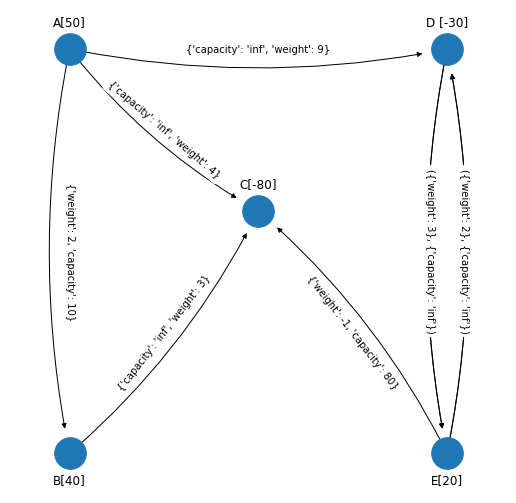

In [111]:
figsize_tuple = (9, 9)
plot_graph_with_edges_trouble_to_visualize(figsize_tuple,
                                           G_simplex3, nodes_and_pos,
                                           nodes_and_pos_modified,
                                           node_labels_simplex3,
                                           string_for_edges_trouble_to_visualize_simplex,
                                           list_of_edges_trouble_to_visualize_simplex)

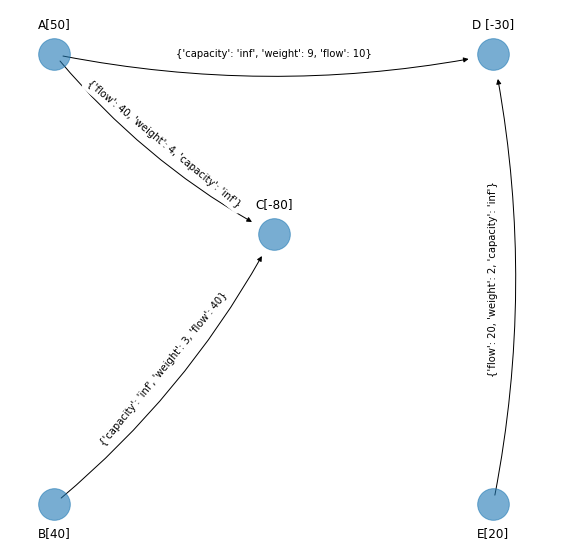

In [112]:
figsize_tuple = (10, 10)
plot_graph(figsize_tuple, G_simplex_spanning_tree_4,
           nodes_and_pos,
           nodes_and_pos_modified,
           node_labels_simplex_spanning_tree_4,
           edge_labels_simplex_spanning_tree_4)

Identificamos los arcos no básicos que son los que no están en el *spanning tree* solución factible que se obtuvo al final de la iteración anterior. En el margen se muestra la red y el *spanning tree* solución factible, entonces los arcos no básicos son $(A,B), (E,C), (D, E)$.

### Revisión de cuál arco no básico sustituye a un arco básico

**Arco $(A,B)$.**

In [113]:
edge_to_be_added_1 = ('A', 'B')

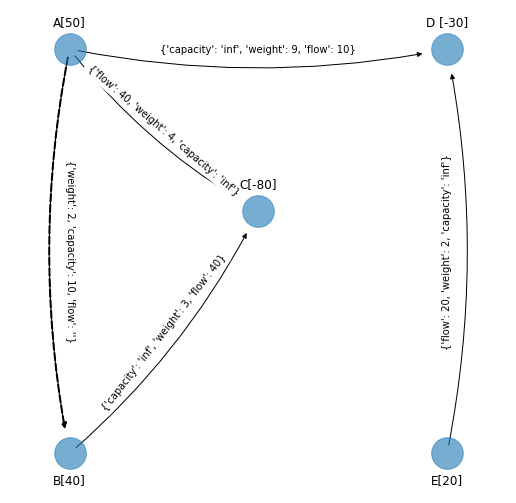

In [114]:
G_simplex_cycle_1, edge_labels_simplex_cycle_1 = add_edge_from_spanning_tree(G_simplex3, G_simplex_spanning_tree_4, 
                                                                             edge_to_be_added_1,
                                                                             edge_labels_simplex_spanning_tree_4)

figsize_tuple = (9, 9)

plot_graph_with_cycle(figsize_tuple, G_simplex_cycle_1,
                      nodes_and_pos,
                      nodes_and_pos_modified,
                      node_labels_simplex_spanning_tree_4,
                      edge_labels_simplex_cycle_1,
                      edge_to_be_added_1)

In [115]:
cycle_1 = nx.find_cycle(G_simplex_cycle_1, source='B', orientation="ignore")
cycle_1_d = {(t[0], t[1]): t[2] for t in cycle_1}
fix_orientation(cycle_1_d, edge_to_be_added_1)

edges_and_weights_simplex_cycle_1 = nx.get_edge_attributes(G_simplex_cycle_1, "weight")

print(np.sum(compute_cost_for_unit_increment(cycle_1_d, 
                                             edges_and_weights_simplex_cycle_1))
     )

1.0


**Arco $(E,C)$.**

In [116]:
edge_to_be_added_2 = ('E', 'C')

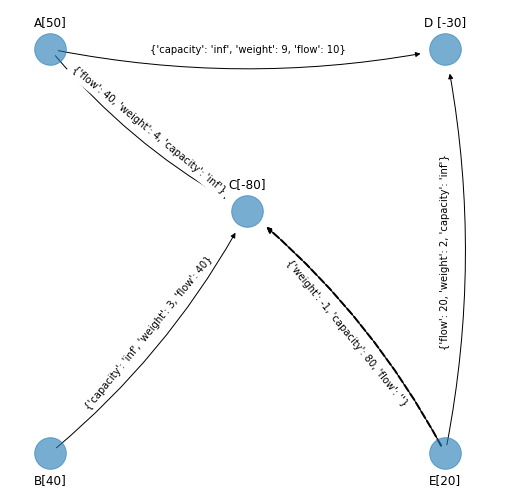

In [117]:
G_simplex_cycle_2, edge_labels_simplex_cycle_2 = add_edge_from_spanning_tree(G_simplex3, G_simplex_spanning_tree_4, 
                                                                             edge_to_be_added_2,
                                                                             edge_labels_simplex_spanning_tree_4)

figsize_tuple = (9, 9)

plot_graph_with_cycle(figsize_tuple, G_simplex_cycle_2,
                      nodes_and_pos,
                      nodes_and_pos_modified,
                      node_labels_simplex_spanning_tree_4,
                      edge_labels_simplex_cycle_2,
                      edge_to_be_added_2)

In [118]:
cycle_2 = nx.find_cycle(G_simplex_cycle_2, source='B', orientation="ignore")
cycle_2_d = {(t[0], t[1]): t[2] for t in cycle_2}
fix_orientation(cycle_2_d, edge_to_be_added_2)

edges_and_weights_simplex_cycle_2 = nx.get_edge_attributes(G_simplex_cycle_2, "weight")

print(np.sum(compute_cost_for_unit_increment(cycle_2_d, 
                                             edges_and_weights_simplex_cycle_2))
     )

2.0


**Arco $(D,E)$.**

In [119]:
edge_to_be_added_3 = ('D', 'E')

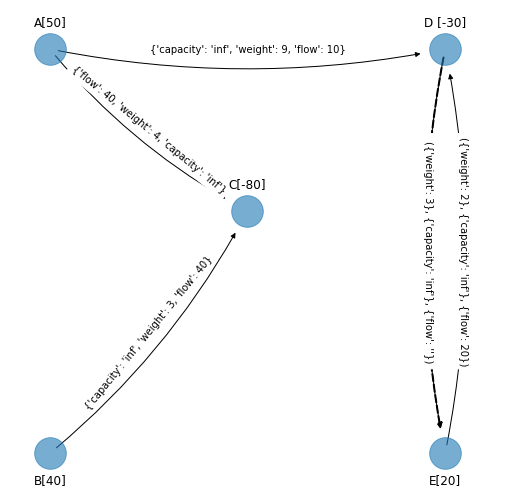

In [120]:
G_simplex_cycle_3, edge_labels_simplex_cycle_3 = add_edge_from_spanning_tree(G_simplex3, G_simplex_spanning_tree_4, 
                                                                             edge_to_be_added_3,
                                                                             edge_labels_simplex_spanning_tree_4)

n1["flow"] = G_simplex_spanning_tree_4['E']['D']["flow"]
n2["flow"] = ""


stri1 = f'{({"weight": n1["weight"]},{"capacity": n1["capacity"]}, {"flow": n1["flow"]},)}'
stri2 = f'\n\n\n'
stri3 = f'{({"weight": n2["weight"]}, {"capacity": n2["capacity"]},{"flow": n2["flow"]})}'
string_for_edges_trouble_to_visualize = {('D', 'E'): ''.join([stri1, stri2, stri3])}

figsize_tuple = (9, 9)
plot_graph_with_cycle_edges_trouble_to_visualize(figsize_tuple,
                                                 G_simplex_cycle_3,
                                                 nodes_and_pos,
                                                 nodes_and_pos_modified,
                                                 node_labels_simplex_spanning_tree_4,
                                                 edge_labels_simplex_cycle_3,
                                                 edge_to_be_added_3,
                                                 string_for_edges_trouble_to_visualize
                                                 )

In [121]:
cycle_3 = nx.find_cycle(G_simplex_cycle_3, source='B', orientation="ignore")
cycle_3_d = {(t[0], t[1]): t[2] for t in cycle_3}
fix_orientation(cycle_3_d, edge_to_be_added_3)

edges_and_weights_simplex_cycle_3 = nx.get_edge_attributes(G_simplex_cycle_3, "weight")

print(np.sum(compute_cost_for_unit_increment(cycle_3_d, 
                                             edges_and_weights_simplex_cycle_3))
     )

5.0


En resúmen:

|Arco | Costo por incrementar una unidad del arco|
|:---:|:---:|
|(A,B)|1|
|(E,C)|2|
|(D,E)|5|

Entonces no hay arcos no básicos que mejoren a $f_o$ por lo que la solución actual es óptima.

## Finalizando el ejemplo

La solución BF óptima corresponde al *spanning tree* solución factible dado por:

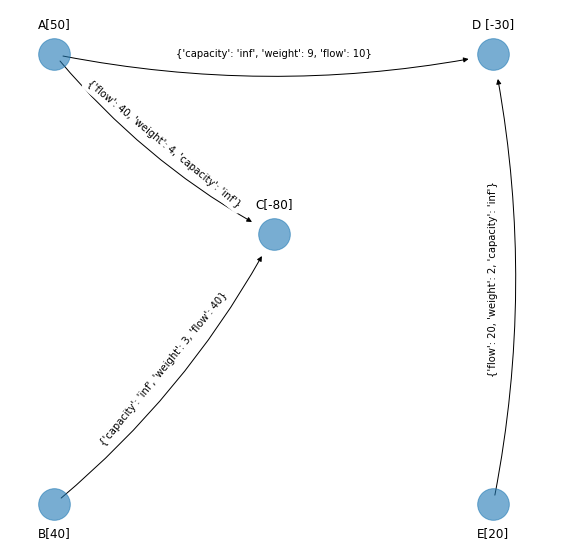

In [122]:
figsize_tuple = (10, 10)
plot_graph(figsize_tuple, G_simplex_spanning_tree_4,
           nodes_and_pos,
           nodes_and_pos_modified,
           node_labels_simplex_spanning_tree_4,
           edge_labels_simplex_spanning_tree_4)

LLegando a este punto debemos comparar la red original que tiene los arcos originales y la última red que debido a la técnica de la cota superior cambió a tales arcos. Se presenta a continuación la última red y en el margen a la red original.

```{margin}

Red original del problema:

```

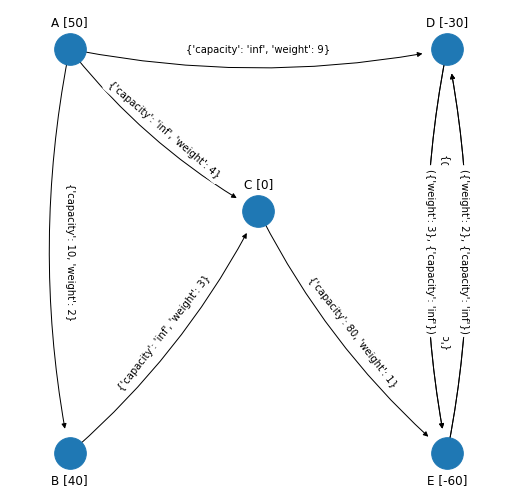

In [123]:
figsize_tuple = (9, 9)
plot_graph_with_edges_trouble_to_visualize(figsize_tuple,
                                           G_min_cost_flow, nodes_and_pos,
                                           nodes_and_pos_modified,
                                           node_labels_min_cost_flow,
                                           string_for_edges_trouble_to_visualize_min_cost_flow,
                                           list_of_edges_trouble_to_visualize_min_cost_flow)

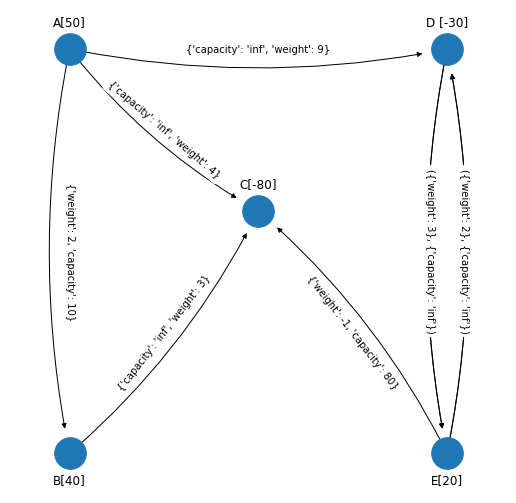

In [124]:
figsize_tuple = (9, 9)
plot_graph_with_edges_trouble_to_visualize(figsize_tuple,
                                           G_simplex3, nodes_and_pos,
                                           nodes_and_pos_modified,
                                           node_labels_simplex3,
                                           string_for_edges_trouble_to_visualize_simplex,
                                           list_of_edges_trouble_to_visualize_simplex)

Hay que revisar las redes anteriores y el último *spanning tree* solución factible con el objetivo de: incluir en el *spanning tree* solución factible aquellos arcos que sean arcos con flujo igual a su cota superior y que pertenezcan a la red original. Tales arcos que serán incluidos tendrán un flujo igual a su capacidad **menos** los valores de los arcos inversos que se produjeron por la técnica de la cota superior.


Para lo anterior podemos consultar `G_simplex_edges_upper_bounds`:

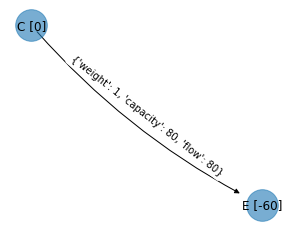

In [125]:
figsize_tuple = (5, 4)
plot_graph(figsize_tuple, G_simplex_edges_upper_bounds,
           nodes_and_pos,
           nodes_and_pos,
           node_labels_simplex_upper_bounds,
           edge_labels_simplex_upper_bounds)

Observamos que todos los arcos conservan su dirección original salvo el $(C,E)$ que fue cambiado por $(E,C)$. Como se tiene la relación: $y_{CE} = 80 - x_{CE}$ y $y_{CE}$ es un arco no básico con valor de $0$ entonces: $y_{CE} = 0$ y $x_{CE}=80$:

In [126]:
print(G_simplex_edges_upper_bounds.edges(data=True))

[('C', 'E', {'weight': 1, 'capacity': 80, 'flow': 80})]


por lo que la red final queda (omitiendo arcos con flujo igual a cero):

In [127]:
edge_to_be_added = ('C', 'E')

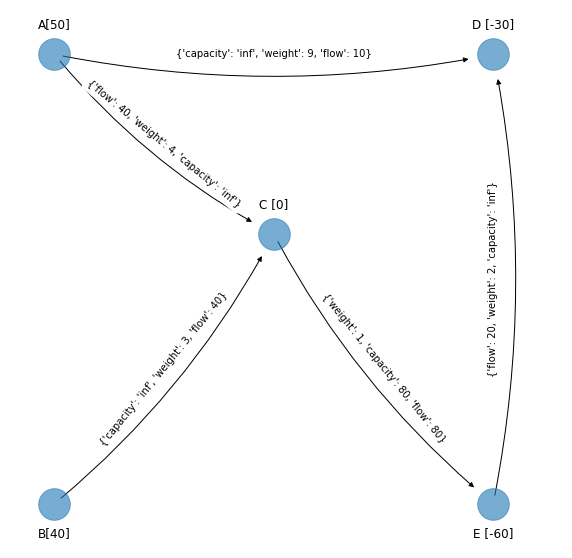

In [128]:
G_simplex_4 = G_simplex_spanning_tree_4.copy()
G_simplex_4.add_edge(edge_to_be_added[0], edge_to_be_added[1])

edge_labels_simplex_4 = copy.deepcopy(edge_labels_simplex_spanning_tree_4)

edge_labels_simplex_4[edge_to_be_added]={}

edge_labels_simplex_4[edge_to_be_added]["weight"] = G_simplex_edges_upper_bounds[edge_to_be_added[0]][edge_to_be_added[1]]["weight"]

edge_labels_simplex_4[edge_to_be_added]["capacity"] = G_simplex_edges_upper_bounds[edge_to_be_added[0]][edge_to_be_added[1]]["capacity"]

edge_labels_simplex_4[edge_to_be_added]["flow"] = G_simplex_edges_upper_bounds[edge_to_be_added[0]][edge_to_be_added[1]]["flow"]


G_simplex_4[edge_to_be_added[0]][edge_to_be_added[1]]["weight"] = edge_labels_simplex_4[edge_to_be_added]["weight"]
G_simplex_4[edge_to_be_added[0]][edge_to_be_added[1]]["capacity"] = edge_labels_simplex_4[edge_to_be_added]["capacity"]
G_simplex_4[edge_to_be_added[0]][edge_to_be_added[1]]["flow"] = edge_labels_simplex_4[edge_to_be_added]["flow"] 


node_labels_simplex_4 = nx.get_node_attributes(G_simplex_4, 
                                               "node_and_netflow")

node_attributes_upper_bounds = nx.get_node_attributes(G_simplex_edges_upper_bounds, "node_and_netflow")

node_labels_simplex_4[edge_to_be_added[0]] = node_attributes_upper_bounds[edge_to_be_added[0]]

node_labels_simplex_4[edge_to_be_added[1]] = node_attributes_upper_bounds[edge_to_be_added[1]]

figsize_tuple = (10, 10)
plot_graph(figsize_tuple, G_simplex_4,
           nodes_and_pos,
           nodes_and_pos_modified,
           node_labels_simplex_4,
           edge_labels_simplex_4)

In [129]:
print(G_simplex_4.edges(data=True))

[('A', 'D', {'capacity': 'inf', 'weight': 9, 'flow': 10}), ('A', 'C', {'flow': 40, 'weight': 4, 'capacity': 'inf'}), ('B', 'C', {'capacity': 'inf', 'weight': 3, 'flow': 40}), ('C', 'E', {'weight': 1, 'capacity': 80, 'flow': 80}), ('E', 'D', {'flow': 20, 'weight': 2, 'capacity': 'inf'})]


```{admonition} Ejercicio
:class: tip

Resuelve el siguiente problema de flujo con costo mínimo visualizando cada paso del método símplex de redes como el ejemplo anterior y muestra la red solución.

```

**Red original:**

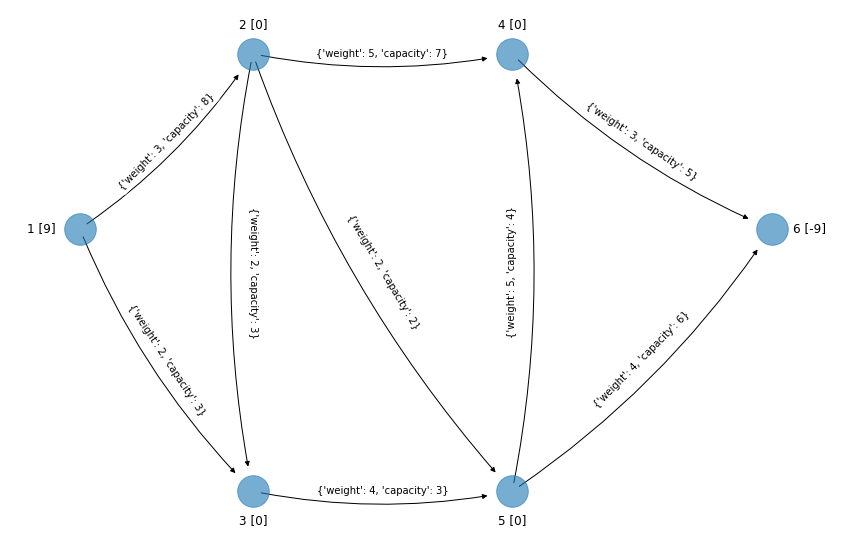

In [130]:
nodes_pos = [[0.09090909090909091, 0.5454545454545454],
             [0.2727272727272727, 0.7272727272727273],
             [0.2727272727272727, 0.2727272727272727],
             [0.5454545454545454, 0.7272727272727273],
             [0.5454545454545454, 0.2727272727272727],
             [0.8181818181818182, 0.5454545454545454]]

nodes = [1, 2, 3, 4, 5, 6]

nodes_and_pos = dict(zip(nodes, nodes_pos))

G_min_cost_flow = nx.DiGraph()

G_min_cost_flow.add_node(1, netflow = 9,  node_and_netflow="1 [9]")
G_min_cost_flow.add_node(2, netflow = 0,  node_and_netflow="2 [0]")
G_min_cost_flow.add_node(3, netflow = 0,  node_and_netflow="3 [0]")
G_min_cost_flow.add_node(4, netflow = 0,  node_and_netflow="4 [0]")
G_min_cost_flow.add_node(5, netflow = 0,  node_and_netflow="5 [0]")
G_min_cost_flow.add_node(6, netflow = -9, node_and_netflow="6 [-9]")


edge_labels_min_cost_flow = {(1, 2): {"weight": 3, "capacity": 8},
                             (1, 3): {"weight": 2, "capacity": 3},
                             (2, 3): {"weight": 2, "capacity": 3},
                             (2, 4): {"weight": 5, "capacity": 7},
                             (2, 5): {"weight": 2, "capacity": 2},
                             (3, 5): {"weight": 4, "capacity": 3},
                             (4, 6): {"weight": 3, "capacity": 5},
                             (5, 4): {"weight": 5, "capacity": 4},
                             (5, 6): {"weight": 4, "capacity": 6}
                            }

G_min_cost_flow.add_edges_from(edge_labels_min_cost_flow)
for e in G_min_cost_flow.edges():
    G_min_cost_flow[e[0]][e[1]]["capacity"] = edge_labels_min_cost_flow[e]["capacity"]
    G_min_cost_flow[e[0]][e[1]]["weight"] = edge_labels_min_cost_flow[e]["weight"]

nodes_and_pos_modified = copy.deepcopy(nodes_and_pos)

node_labels_min_cost_flow = nx.get_node_attributes(G_min_cost_flow, "node_and_netflow")

y_off = 0.03
x_off = 0.04

for node in G_min_cost_flow.nodes():
    if node == 1:
        nodes_and_pos_modified[node] = [nodes_and_pos_modified[node][0] - x_off, 
                                        nodes_and_pos_modified[node][1]]
    else:
        if node == 2 or node == 4:
            nodes_and_pos_modified[node] = [nodes_and_pos_modified[node][0], 
                                            nodes_and_pos_modified[node][1] + y_off]
        else:
            if node == 3 or node ==5:
                nodes_and_pos_modified[node] = [nodes_and_pos_modified[node][0], 
                                                nodes_and_pos_modified[node][1] - y_off]  
            else:
                nodes_and_pos_modified[node] = [nodes_and_pos_modified[node][0] + x_off, 
                                                nodes_and_pos_modified[node][1]]                

figsize_tuple = (15, 10)

plot_graph(figsize_tuple, G_min_cost_flow,
           nodes_and_pos,
           nodes_and_pos_modified,
           node_labels_min_cost_flow,
           edge_labels_min_cost_flow)

Supóngase que en alguna iteración se aplicó la técnica de la cota superior a más de un arco por lo que la red modificada quedó como sigue:

In [131]:
edge_inverse1 = (3, 1)
edge_inverse2 = (5, 3)
edge_inverse3 = (6, 4)

tuple_edges_inverse = (edge_inverse1, edge_inverse2, edge_inverse3)

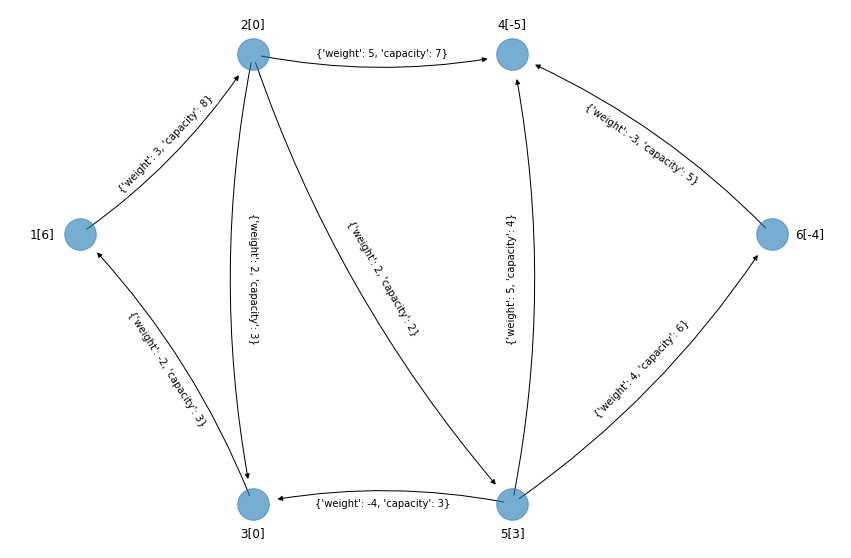

In [132]:
G_simplex = G_min_cost_flow.copy()

G_simplex.remove_edge(3, 5)
G_simplex.remove_edge(1, 3)
G_simplex.remove_edge(4, 6)

for e in tuple_edges_inverse:
    G_simplex.add_edge(e[0], e[1])

list_edges_simplex = G_simplex.edges()

edge_labels_simplex = {}

for e in list_edges_simplex:
    if e not in tuple_edges_inverse:
        edge_labels_simplex[e] = copy.deepcopy(edge_labels_min_cost_flow[e])
        
        
for e in tuple_edges_inverse:
    edge_labels_simplex[e] = {}
    edge_labels_simplex[e]["weight"] = - edge_labels_min_cost_flow[(e[1], e[0])]["weight"]
    edge_labels_simplex[e]["capacity"] = edge_labels_min_cost_flow[(e[1], e[0])]["capacity"]
    

new_netflow_1 = 6
new_netflow_2 = 0
new_netflow_3 = 0
new_netflow_4 = -5
new_netflow_5 = 3
new_netflow_6 = -4

node_and_netflow_1 = "".join(['1', '[', str(new_netflow_1),']'])
node_and_netflow_2 = "".join(['2', '[', str(new_netflow_2),']'])
node_and_netflow_3 = "".join(['3', '[', str(new_netflow_3),']'])
node_and_netflow_4 = "".join(['4', '[', str(new_netflow_4),']'])
node_and_netflow_5 = "".join(['5', '[', str(new_netflow_5),']'])
node_and_netflow_6 = "".join(['6', '[', str(new_netflow_6),']'])

    
nx.set_node_attributes(G_simplex, {1: {"netflow": new_netflow_1,
                                       "node_and_netflow": node_and_netflow_1},
                                   2: {"netflow": new_netflow_2,
                                       "node_and_netflow": node_and_netflow_2},
                                   3: {"netflow": new_netflow_3,
                                      "node_and_netflow": node_and_netflow_3},
                                   4: {"netflow": new_netflow_4,
                                      "node_and_netflow": node_and_netflow_4},
                                   5: {"netflow": new_netflow_5,
                                      "node_and_netflow": node_and_netflow_5},
                                   6: {"netflow": new_netflow_6,
                                      "node_and_netflow": node_and_netflow_6}})



for e in G_simplex.edges():
    G_simplex[e[0]][e[1]]["weight"] =   edge_labels_simplex[e]["weight"]
    G_simplex[e[0]][e[1]]["capacity"] = edge_labels_simplex[e]["capacity"]


node_labels_simplex = nx.get_node_attributes(G_simplex, 
                                             "node_and_netflow")

figsize_tuple = (15, 10)
plot_graph(figsize_tuple, G_simplex,
           nodes_and_pos,
           nodes_and_pos_modified,
           node_labels_simplex,
           edge_labels_simplex)
    

Utilizar el siguiente *spanning tree* solución factible:

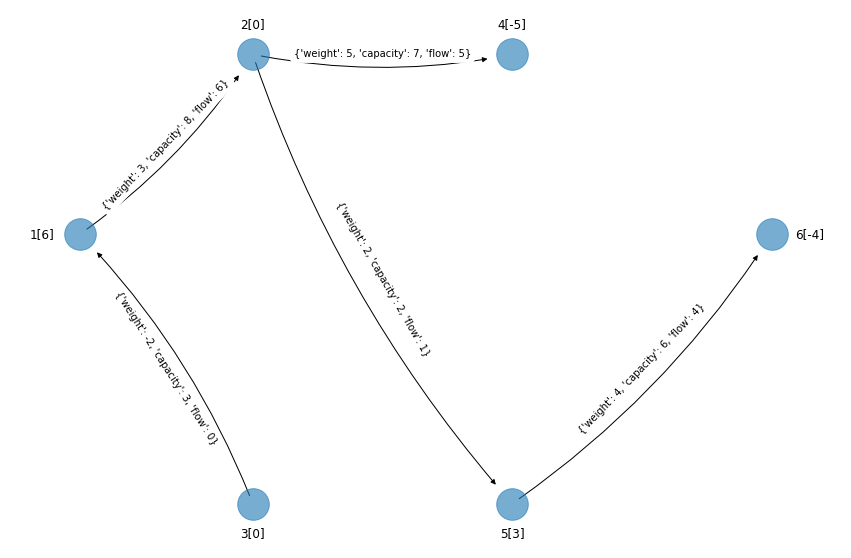

In [133]:
G_simplex_spanning_tree_1 = G_simplex.copy()
G_simplex_spanning_tree_1.remove_edge(2, 3)
G_simplex_spanning_tree_1.remove_edge(5, 4)
G_simplex_spanning_tree_1.remove_edge(tuple_edges_inverse[1][0], tuple_edges_inverse[1][1])
G_simplex_spanning_tree_1.remove_edge(tuple_edges_inverse[2][0], tuple_edges_inverse[2][1])


node_labels_simplex_spanning_tree_1 = nx.get_node_attributes(G_simplex_spanning_tree_1, 
                                                             "node_and_netflow")
list_edges_spanning_tree_1 = G_simplex_spanning_tree_1.edges()

edge_labels_simplex_spanning_tree_1 = {}

for e in list_edges_spanning_tree_1:
    edge_labels_simplex_spanning_tree_1[e] = copy.deepcopy(edge_labels_simplex[e])
    
edge_labels_simplex_spanning_tree_1[(1, 2)]["flow"] = 6
edge_labels_simplex_spanning_tree_1[(2, 5)]["flow"] = 1
edge_labels_simplex_spanning_tree_1[(2, 4)]["flow"] = 5
edge_labels_simplex_spanning_tree_1[(5, 6)]["flow"] = 4
edge_labels_simplex_spanning_tree_1[(3, 1)]["flow"] = 0

for e in G_simplex_spanning_tree_1.edges():
    G_simplex_spanning_tree_1[e[0]][e[1]]["flow"] = edge_labels_simplex_spanning_tree_1[e]["flow"]
        
figsize_tuple = (15, 10)
plot_graph(figsize_tuple, G_simplex_spanning_tree_1,
           nodes_and_pos,
           nodes_and_pos_modified,
           node_labels_simplex_spanning_tree_1,
           edge_labels_simplex_spanning_tree_1)

Y el siguiente conjunto de *nontree arcs* del *spanning tree* solución factible anterior:

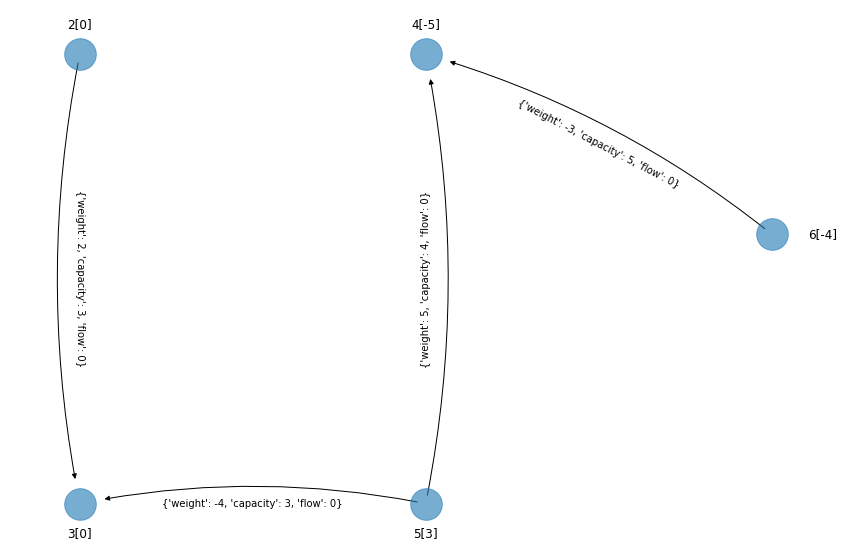

In [134]:
G_non_tree_arcs_1 = G_simplex.copy()

G_non_tree_arcs_1.remove_node(1)
G_non_tree_arcs_1.remove_edge(2, 4)
G_non_tree_arcs_1.remove_edge(2, 5)
G_non_tree_arcs_1.remove_edge(5, 6)

list_edges_non_tree_arcs = G_non_tree_arcs_1.edges()

edge_labels_non_tree_arcs = {}

for e in list_edges_non_tree_arcs:
    edge_labels_non_tree_arcs[e] = copy.deepcopy(edge_labels_simplex[e])
    edge_labels_non_tree_arcs[e]["flow"] = 0
        

edge_labels_non_tree_arcs[(2, 3)] = copy.deepcopy(edge_labels_simplex[(2, 3)])
edge_labels_non_tree_arcs[(5, 4)] = copy.deepcopy(edge_labels_simplex[(5, 4)])
edge_labels_non_tree_arcs[(2, 3)]["flow"] = 0
edge_labels_non_tree_arcs[(5, 4)]["flow"] = 0    
    
node_labels_non_tree_arcs = nx.get_node_attributes(G_non_tree_arcs_1, 
                                                   "node_and_netflow")
    
figsize_tuple = (15, 10)
plot_graph(figsize_tuple, G_non_tree_arcs_1,
           nodes_and_pos,
           nodes_and_pos_modified,
           node_labels_non_tree_arcs,
           edge_labels_non_tree_arcs)    

Los arcos que tienen un flujo igual al valor de sus cotas superiores son: $(1,3), (3, 5), (4, 6)$.

In [135]:
tuple_edges_in_upper_bounds = ((1,3), (3, 5), (4, 6))

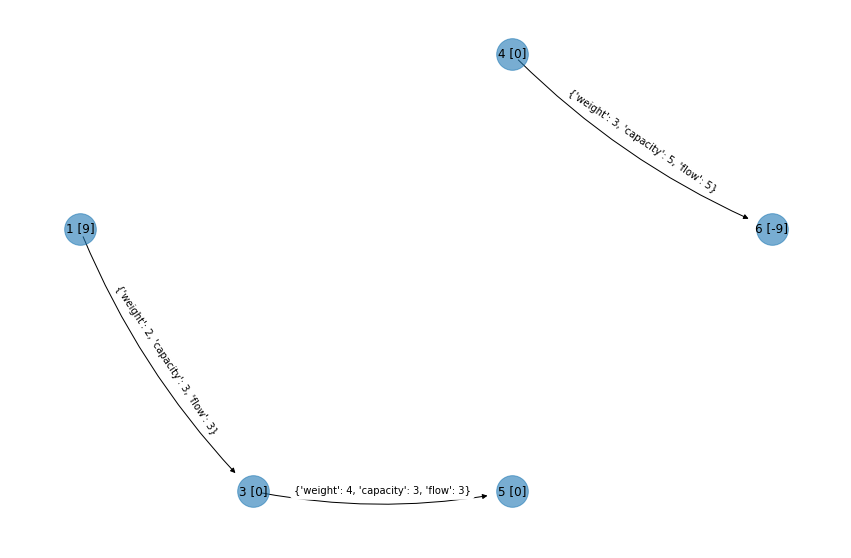

In [136]:
edge_labels_simplex_upper_bounds = {}
G_simplex_edges_upper_bounds = nx.DiGraph()

for e in tuple_edges_in_upper_bounds:
    G_simplex_edges_upper_bounds.add_node(e[0])
    G_simplex_edges_upper_bounds.add_node(e[1])
    
    G_simplex_edges_upper_bounds = add_edge_to_graph_of_upper_bounds(G_min_cost_flow,
                                                                     G_simplex_edges_upper_bounds,
                                                                     e,
                                                                     edge_labels_simplex_upper_bounds)
    
node_labels_simplex_upper_bounds = nx.get_node_attributes(G_simplex_edges_upper_bounds, "node_and_netflow")

figsize_tuple = (15, 10)
plot_graph(figsize_tuple, G_simplex_edges_upper_bounds,
           nodes_and_pos,
           nodes_and_pos,
           node_labels_simplex_upper_bounds,
           edge_labels_simplex_upper_bounds)    

```{admonition} Ejercicios
:class: tip

1.Resuelve los ejercicios y preguntas de la nota.
```


**Referencias:**

1. F. Hillier, G. Lieberman, Introduction to Operations Research, Mc Graw Hill, 2014.

2. R. K. Ahuja, T. L. Magnanti, J. B. Orlin, Network Flows, Theory, Algorithms and Applications, Prentice Hall, 1993.